In [2]:
import torch
import numpy as np
import os
import pandas as pd
import random
from tqdm import tqdm

from torch import nn
import torch.nn.functional as F

random.seed(42)

In [3]:
data_dir = '../osic-pulmonary-fibrosis-progression'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "preprocessing")))

from preprocess import preprocess_scans, get_preprocessed_scan

import matplotlib.pyplot as plt
if not os.path.exists(os.path.join(data_dir, 'preprocessed_scans')):
    preprocess_scans(data_dir)
# scan = get_preprocessed_scan(data_dir, 'ID00009637202177434476278', 190)
# plt.imshow(scan.squeeze(), cmap='gray')
# plt.show()

Using device: cuda


In [5]:
# Input: List of patient_id
# Output: Tuple of (train_patient_ids, val_patient_ids)
# train_ratio: Ratio of training set
def train_val_split(patients: pd.DataFrame, train_ratio: float = 0.8) -> (pd.DataFrame, pd.DataFrame):
  patient_ids = patients['Patient'].unique()
  # Remove patient with unopenable scan
  patient_ids = [id for id in patient_ids if id != "ID00011637202177653955184"]
  random.shuffle(patient_ids)

  train_patients = patients[patients['Patient'].isin(patient_ids[:int(len(patient_ids) * train_ratio)])]
  val_patients = patients[patients['Patient'].isin(patient_ids[int(len(patient_ids) * train_ratio):])]

  return train_patients, val_patients

In [6]:
# Prepare train and val data
train_datas = pd.read_csv(data_dir + '/train.csv')
test_datas = pd.read_csv(data_dir + '/test.csv')

bad_scan_patients = ['ID00026637202179561894768']

test_patient_ids = test_datas['Patient'].unique()

# Remove row in train data if patient_id is in test_patient_ids
test_datas = train_datas[train_datas['Patient'].isin(test_patient_ids)]
train_datas = train_datas[~train_datas['Patient'].isin(test_patient_ids)]
train_datas = train_datas[~train_datas['Patient'].isin(bad_scan_patients)]

# Sort df by patient and then by 'Weeks'
train_datas = train_datas.sort_values(by=['Patient', 'Weeks'])

# Group by patient and get the first FVC value and weeks
patient_id_to_initial_FVC = train_datas.groupby('Patient')['FVC'].first().to_dict()
patient_id_to_initial_weeks = train_datas.groupby('Patient')['Weeks'].first().to_dict()

train_datas, val_datas = train_val_split(train_datas)

# Count the number of scans for each patient
scan_count = {}
test_scan_count = {}
for patient_id in os.listdir(os.path.join(data_dir, 'train')):
    scan_count[patient_id] = len(os.listdir(os.path.join(data_dir, 'train', patient_id)))
    
    if patient_id in test_patient_ids:
        test_scan_count[patient_id] = len(os.listdir(os.path.join(data_dir, 'test', patient_id)))

test_patient_id_to_initial_FVC = test_datas.groupby('Patient')['FVC'].first().to_dict()
test_patient_id_to_initial_weeks = test_datas.groupby('Patient')['Weeks'].first().to_dict()

In [7]:
from collections import defaultdict

train_x, train_y = defaultdict(list), defaultdict(list)

for idx, row in train_datas.iterrows():
    train_x[row['Patient']].append({
        'Weeks': row['Weeks'],
        'initial_FVC': patient_id_to_initial_FVC[row['Patient']],
        'initial_weeks': patient_id_to_initial_weeks[row['Patient']],
    })
    train_y[row['Patient']].append(row['FVC'])

val_x, val_y = defaultdict(list), defaultdict(list)

for idx, row in val_datas.iterrows():
    val_x[row['Patient']].append({
        'Weeks': row['Weeks'],
        'initial_FVC': patient_id_to_initial_FVC[row['Patient']],
        'initial_weeks': patient_id_to_initial_weeks[row['Patient']],
    })
    val_y[row['Patient']].append(row['FVC'])

test_x, test_y = defaultdict(list), defaultdict(list)

for idx, row in test_datas.iterrows():
    test_x[row['Patient']].append({
        'Weeks': row['Weeks'],
        'initial_FVC': test_patient_id_to_initial_FVC[row['Patient']],
        'initial_weeks': test_patient_id_to_initial_weeks[row['Patient']],
    })
    test_y[row['Patient']].append(row['FVC'])


In [8]:
# Use training data to gather tabular data statistics
# Compute statistics

initial_weeks = list(patient_id_to_initial_weeks.values())

tabular_stats = {
    'weeks_mean': train_datas['Weeks'].mean(),
    'weeks_std': train_datas['Weeks'].std(),
    'initial_fvc_mean': train_datas['FVC'].mean(),
    'initial_fvc_std': train_datas['FVC'].std(),
    'initial_weeks_mean': np.mean(initial_weeks),
    'initial_weeks_std': np.std(initial_weeks),
}

print("Normalization Statistics:")
print(f"Weeks: mean={tabular_stats['weeks_mean']:.2f}, std={tabular_stats['weeks_std']:.2f}")
print(f"FVC:   mean={tabular_stats['initial_fvc_mean']:.2f}, std={tabular_stats['initial_fvc_std']:.2f}")
print(f"Weeks: mean={tabular_stats['initial_weeks_mean']:.2f}, std={tabular_stats['initial_weeks_std']:.2f}")

Normalization Statistics:
Weeks: mean=31.96, std=23.10
FVC:   mean=2697.31, std=854.78
Weeks: mean=14.37, std=15.32


In [9]:
import matplotlib.pyplot as plt
import math

# window = 0 to remove smoothing
def plot_loss(training_loss, val_loss, window=20):
    # Use sliding window to smooth the loss
    training_loss = [sum(training_loss[i:i+window]) / window for i in range(len(training_loss)-window)]
    val_loss = [sum(val_loss[i:i+window]) / window for i in range(len(val_loss)-window)]

    # Create one row, two col subplots
    fig, axs = plt.subplots(1, 2, figsize=(10, 6))
    axs[0].plot(range(len(training_loss)), [math.log(x) for x in training_loss], label='Training Loss')
    axs[0].set_xlabel('Iteration')
    axs[0].set_ylabel('Loss')
    axs[0].set_title('Training Loss')
    axs[0].legend()
    axs[0].grid(True)
    axs[1].plot(range(len(val_loss)), [math.log(x) for x in val_loss], label='Validation Loss', color='orange')
    axs[1].set_xlabel('Iteration')
    axs[1].set_ylabel('Loss')
    axs[1].set_title('Validation Loss')
    axs[1].legend()

In [10]:
import cv2
from preprocess import get_preprocessed_scan

def get_scans(patient_id: str, patient_scan_count: int, scan_batch_size: int) -> torch.Tensor:
    skip_size = patient_scan_count // scan_batch_size
    remainder = patient_scan_count % scan_batch_size
    scans = []
    curr = 0
    while curr < patient_scan_count:
        scan = get_preprocessed_scan(data_dir, patient_id, curr+1)
        if scan is None:
            continue

        scan = torch.tensor(scan, dtype=torch.float32, device=device)
        if scan.shape[1] != 512:
            scan = scan.cpu().numpy().squeeze()
            resized_scan = cv2.resize(scan, (512, 512), interpolation=cv2.INTER_LINEAR)
            scan = resized_scan.reshape(1, 512, 512)
            scan = torch.tensor(scan, dtype=torch.float32, device=device)
        scans.append(scan)

        curr += skip_size
        # Ensure exactly #scan_batch_size number of scans
        if remainder > 0:
            remainder -= 1
            curr += 1
        
    scans = torch.stack(scans)
    return scans

In [11]:
from preprocess import get_test_preprocessed_scan

def test_model(cnn_model, fc_model, scan_batch_size=64):
    cnn_model.to(device)
    fc_model.to(device)

    cnn_model.eval()
    fc_model.eval()

    test_predictions = []
    test_target = []

    for patient_id in tqdm(test_patient_ids):
        patient_scan_count = test_scan_count[patient_id]
        scans = get_scans(patient_id, patient_scan_count, scan_batch_size)
        features = cnn_model.forward(scans)
        features = torch.mean(features, dim=0) # 1024,

        x = test_x[patient_id]
        y = test_y[patient_id]

        for i in range(len(x)):
            weeks = torch.tensor(x[i]['Weeks'], dtype=torch.float32, device=device).unsqueeze(0)
            initial_FVC = torch.tensor(x[i]['initial_FVC'], dtype=torch.float32, device=device).unsqueeze(0)
            initial_FVC_weeks = torch.tensor(x[i]['initial_weeks'], dtype=torch.float32, device=device).unsqueeze(0)

            output = fc_model.forward(features, weeks, initial_FVC, initial_FVC_weeks).squeeze()
            test_predictions.append(output.item())
            test_target.append(y[i])

        del x, y, features, scans, weeks, initial_FVC, initial_FVC_weeks, output
        torch.cuda.empty_cache()
    
    return torch.tensor(test_predictions), torch.tensor(test_target)

In [12]:
# Quick visualization
def plot_test_results(targets, predictions):
    fig, ax = plt.subplots(figsize=(7, 5))
    ax.scatter(targets, predictions, alpha=0.5)
    ax.plot([min(targets), max(targets)], [min(targets), max(targets)], 'r--')
    ax.set_xlabel('Target')
    ax.set_ylabel('Prediction')
    ax.set_title('Predictions vs Targets')

    plt.tight_layout()
    plt.show()

In [13]:
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import dendrogram, linkage

def run_feature_analysis(all_features):

    # Compute pairwise distances
    features_array = torch.stack(all_features).cpu().numpy()
    distances = squareform(pdist(features_array, metric='euclidean'))

    # Compute average distance for each patient (excluding self-distance)
    avg_dist = (distances.sum(axis=1) - np.diag(distances)) / (distances.shape[1] - 1)
    # Get 10 indexes with highest average distance to others
    top_10_outliers = np.argsort(-avg_dist)[:10]

    # Heatmap of patient similarities
    plt.figure(figsize=(10, 8))
    plt.imshow(distances, cmap='coolwarm')
    plt.colorbar(label='Euclidean Distance')
    plt.title('Patient-to-Patient CNN Feature Similarity')
    plt.xlabel('Patient Index')
    plt.ylabel('Patient Index')
    plt.tight_layout()
    plt.show()

    # Clustering in scatter plot
    from sklearn.cluster import AgglomerativeClustering

    # Fit hierarchical clustering and get cluster labels
    n_clusters = 3  # You can change the number of clusters as needed
    clustering = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='ward')
    cluster_labels = clustering.fit_predict(features_array)

    # Scatter plot of first two principal components colored by cluster
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    reduced_features = pca.fit_transform(features_array)

    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(
        reduced_features[:, 0],
        reduced_features[:, 1],
        c=cluster_labels,
        cmap='tab10',
        s=40,
        alpha=0.7
    )
    plt.title('Patient Clustering in CNN Feature Space (PCA)')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.colorbar(scatter, label='Cluster Label')
    plt.tight_layout()
    plt.show()

    # Check if features are actually collapsed
    features_tensor = torch.stack(all_features)

    # 1. Check for dead features
    dead_features = (features_tensor.max(dim=0)[0] == 0).sum()
    print(f"Dead features (always 0): {dead_features}/{features_tensor.shape[1]}")

    # 2. Check feature value ranges
    print(f"Feature min: {features_tensor.min():.3f}")
    print(f"Feature max: {features_tensor.max():.3f}")
    print(f"Feature mean: {features_tensor.mean():.3f}")
    print(f"Feature std: {features_tensor.std():.3f}")

    # 3. Check how many features are near zero
    near_zero = (features_tensor.abs() < 0.01).float().mean()
    print(f"Percentage of near-zero activations: {near_zero*100:.1f}%")

    # # 4. Investigate the outlier patient
    # outlier_idx = 45  # Adjust based on actual index
    # print(f"\nOutlier patient: {patient_ids[outlier_idx]}")
    # print(f"Outlier features range: {features_tensor[outlier_idx].min():.3f} to {features_tensor[outlier_idx].max():.3f}")
    return top_10_outliers

In [14]:

def plot_patient_predict_samples(cnn_model, fc_model, criterion, scan_batch_size):
    cnn_model.eval()
    fc_model.eval()

    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    # avg_loss = 0
    # for patient_id in list(train_x.keys()):
    #     scans = get_scans(patient_id, scan_count[patient_id], 64)
    #     features = torch.mean(cnn_model.forward(scans), dim=0)
    #     x = train_x[patient_id]
    #     y = train_y[patient_id]

    #     for i in range(len(x)):
    #         weeks = torch.tensor(x[i]['Weeks'], dtype=torch.float32, device=device).unsqueeze(0)
    #         initial_FVC = torch.tensor(x[i]['initial_FVC'], dtype=torch.float32, device=device).unsqueeze(0)
    #         initial_FVC_weeks = torch.tensor(x[i]['initial_weeks'], dtype=torch.float32, device=device).unsqueeze(0)
    #         output = fc_model.forward(features, weeks, initial_FVC, initial_FVC_weeks).squeeze()
    #         avg_loss += criterion(output, torch.tensor(y[i], dtype=torch.float32, device=device)).item()
    
    # avg_loss /= len(list(train_x.keys()))
    # print(f'Average Loss: {avg_loss}')
    with torch.no_grad():
        all_features = []
        for patient_order, patient in enumerate(list(train_x.keys())):
            scans = get_scans(patient, scan_count[patient], scan_batch_size)
            features = cnn_model.forward(scans)
            # features = features.flatten()
            features = torch.mean(cnn_model.forward(scans), dim=0)
            all_features.append(features)
            x = train_x[patient]
            y = train_y[patient]

            predictions = []
            losses = []
            for i in range(len(x)):
                weeks = torch.tensor(x[i]['Weeks'], dtype=torch.float32, device=device).unsqueeze(0)
                initial_FVC = torch.tensor(x[i]['initial_FVC'], dtype=torch.float32, device=device).unsqueeze(0)
                initial_FVC_weeks = torch.tensor(x[i]['initial_weeks'], dtype=torch.float32, device=device).unsqueeze(0)
                output = fc_model.forward(features, weeks, initial_FVC, initial_FVC_weeks).squeeze()
                predictions.append(output.item())
                losses.append(criterion(output, torch.tensor(y[i], dtype=torch.float32, device=device)))
            
            # print(f'{patient} Average Loss: {sum(losses) / len(losses)}')

            # # Visualize activation levels as a line plot
            # norm_weeks = (weeks - tabular_stats['weeks_mean']) / tabular_stats['weeks_std']
            # norm_initial_FVC = (initial_FVC - tabular_stats['initial_fvc_mean']) / tabular_stats['initial_fvc_std']
            # norm_initial_FVC_weeks = (initial_FVC_weeks - tabular_stats['initial_weeks_mean']) / tabular_stats['initial_weeks_std']
            # tab_features = torch.cat([norm_weeks, norm_initial_FVC, norm_initial_FVC_weeks])
            # tab_features = F.relu(fc_model.tabular_expansion_fc1(tab_features))
            # tab_features = F.relu(fc_model.tabular_expansion_fc2(tab_features))
            # combined_features = torch.cat([features, tab_features])
            
            # feat = fc_model.fc1(combined_features)
            # feat = F.relu(feat)
            # feat = fc_model.fc2(feat)
            # feat = F.relu(feat)
            # print(feat)
            # feat = fc_model.fc3(feat)

            # How does 'week' feature affect the prediction?
            # weeks = torch.tensor(0, dtype=torch.float32, device=device).unsqueeze(0)
            # pred_week_0 = fc_model(features, weeks, initial_FVC, initial_FVC_weeks)
            # weeks = torch.tensor(50, dtype=torch.float32, device=device).unsqueeze(0)
            # pred_week_50 = fc_model(features, weeks, initial_FVC, initial_FVC_weeks)
            # weeks = torch.tensor(100, dtype=torch.float32, device=device).unsqueeze(0)
            # pred_week_100 = fc_model(features, weeks, initial_FVC, initial_FVC_weeks)
            # print(pred_week_0.item(), pred_week_50.item(), pred_week_100.item())
            if patient_order < 4:
                row = patient_order // 2
                col = patient_order % 2

                weeks = [point['Weeks'] for point in x]
                # Plot prediction vs actual for each patient
                axes[row][col].scatter(weeks, y, color='blue', alpha=0.7, s=80, label='Actual', edgecolors='darkblue', linewidth=0.5)
                axes[row][col].scatter(weeks, predictions, color='red', alpha=0.7, s=80, label='Predicted', edgecolors='darkred', linewidth=0.5)
                
                axes[row][col].set_xlabel('Weeks', fontsize=11, fontweight='bold')
                axes[row][col].set_ylabel('FVC', fontsize=11, fontweight='bold')
                axes[row][col].set_title(f'Patient {patient}', fontsize=12, fontweight='bold', pad=10)
                axes[row][col].legend(loc='best', frameon=True, shadow=True)
                axes[row][col].grid(True, alpha=0.3, linestyle='--')
                axes[row][col].tick_params(labelsize=10)

    top_10_outliers = run_feature_analysis(all_features)
    print("Top 10 Outliers")
    for outlier in top_10_outliers:
        print(f'Idx: {outlier}, Patient ID: {list(train_x.keys())[outlier]}')

    # # Do inter-patient scan feature analysis
    # scan_feat_mean = torch.mean(torch.stack(all_features), dim=0)
    # scan_feat_std = torch.std(torch.stack(all_features), dim=0)
    # print(f'Across patients, scan feat mean = {scan_feat_mean}, scan feat std = {scan_feat_std}')

    # Add spacing between subplots
    plt.tight_layout(pad=5.0, h_pad=5.0, w_pad=5.0)

    # Or alternatively, use subplots_adjust for more control:
    # plt.subplots_adjust(left=0.08, right=0.95, bottom=0.08, top=0.95, hspace=0.3, wspace=0.3)

    plt.suptitle('FVC Predictions vs Actual Values', fontsize=16, fontweight='bold', y=0.995)
    del weeks, initial_FVC, initial_FVC_weeks, predictions, scans, features, output
    torch.cuda.empty_cache()
    plt.show()


In [15]:
def visualize_cnn_activation(cnn_model, layer):
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    patient_id = list(train_x.keys())[50]
    scans = get_scans(patient_id, scan_count[patient_id], 12)
    
    # Make a binary mask
    input_mask = (scans.abs() != 0).float()
    # Fill mask using binary morphological closing (remove small holes/gaps)
    import torch.nn.functional as F
    kernel = torch.ones((1, 1, 7, 7), device=input_mask.device)
    # Pad to keep size
    padded_mask = F.pad(input_mask, (3, 3, 3, 3), mode='replicate')
    closed_mask = F.conv2d(padded_mask, kernel, padding=0) > 0
    closed_mask = closed_mask.float()
    # Smooth mask with a Gaussian kernel
    smoothed_mask = F.avg_pool2d(closed_mask, kernel_size=7, stride=1, padding=3)
    input_mask = (smoothed_mask > 0.2).float()  # threshold for clear mask

    with torch.no_grad():
        x = cnn_model.conv1(scans)
        x = F.relu(cnn_model.bn1(x))
        mask = F.interpolate(input_mask, size=(512, 512), mode='bilinear', align_corners=False)
        x = x * mask
        x = cnn_model.pool(x)

        if layer == 1:
            for i, feature in enumerate(x[1::3]):
                x = torch.mean(feature, dim=0)
                im = axes[i // 2][i % 2].imshow(x.cpu(), cmap='viridis')
                axes[i // 2][i % 2].set_title(f"Activation {i}")
                plt.colorbar(im, ax=axes[i // 2][i % 2], fraction=0.046, pad=0.04)
            return

        x = cnn_model.conv2(x)
        x = F.relu(cnn_model.bn2(x))
        mask = F.interpolate(input_mask, size=(256, 256), mode='bilinear', align_corners=False)
        x = x * mask
        x = cnn_model.pool(x) # num_slices, 64, 128, 128

        if layer == 2:
            for i, feature in enumerate(x[1::3]):
                x = torch.mean(feature, dim=0)
                im = axes[i // 2][i % 2].imshow(x.cpu(), cmap='viridis')
                axes[i // 2][i % 2].set_title(f"Activation {i}")
                plt.colorbar(im, ax=axes[i // 2][i % 2], fraction=0.046, pad=0.04)
            return

        x = cnn_model.conv3(x)
        x = F.relu(cnn_model.bn3(x))
        mask = F.interpolate(input_mask, size=(128, 128), mode='bilinear', align_corners=False)
        x = x * mask
        x = cnn_model.pool(x) # num_slices, 128, 64, 64
        
        if layer == 3:
            for i, feature in enumerate(x[1::3]):
                x = torch.mean(feature, dim=0)
                im = axes[i // 2][i % 2].imshow(x.cpu(), cmap='viridis')
                axes[i // 2][i % 2].set_title(f"Activation {i}")
                plt.colorbar(im, ax=axes[i // 2][i % 2], fraction=0.046, pad=0.04)
            return

        x = cnn_model.conv4(x)
        x = F.relu(cnn_model.bn4(x))
        mask = F.interpolate(input_mask, size=(64, 64), mode='bilinear', align_corners=False)
        x = x * mask
        x = cnn_model.pool(x) # num_slices, 256, 32, 32

        if layer == 4:
            for i, feature in enumerate(x[1::3]):
                x = torch.mean(feature, dim=0)
                im = axes[i // 2][i % 2].imshow(x.cpu(), cmap='viridis')
                axes[i // 2][i % 2].set_title(f"Activation {i}")
                plt.colorbar(im, ax=axes[i // 2][i % 2], fraction=0.046, pad=0.04)
            # Visualize all features at once for this layer
            # num_features = x.shape[1]
            # num_cols = 4
            # num_rows = int(np.ceil(num_features / num_cols))
            # fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 4, num_rows * 4))
            # for i in range(num_features):
            #     # Take the middle slice for visualization (or choose another one as needed)
            #     feature_map = x[x.shape[0] // 2, i].cpu()
            #     row, col = divmod(i, num_cols)
            #     ax = axes[row, col] if num_rows > 1 else axes[col]
            #     im = ax.imshow(feature_map, cmap='viridis')
            #     ax.set_title(f"Feature {i}")
            #     ax.axis('off')
            #     plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
            # for j in range(num_features, num_rows * num_cols):
            #     fig.delaxes(axes.flatten()[j])
            # plt.tight_layout()
            # plt.show()
            return

        x = F.relu(cnn_model.bn5(cnn_model.conv5(x)))
        mask = F.interpolate(input_mask, size=(32, 32), mode='bilinear', align_corners=False)
        x = x * mask
        x = cnn_model.pool(x) # num_slices, 512, 16, 16

        if layer == 5:
            for i, feature in enumerate(x[1::3]):
                x = torch.mean(feature, dim=0)
                im = axes[i // 2][i % 2].imshow(x.cpu(), cmap='viridis')
                axes[i // 2][i % 2].set_title(f"Activation {i}")
                plt.colorbar(im, ax=axes[i // 2][i % 2], fraction=0.046, pad=0.04)
            return

        x = cnn_model.global_pool(x) # num_slices, 512, 1, 1
        plt.figure(figsize=(10, 6))
        heatmap = x.squeeze().cpu().numpy()
        if heatmap.ndim == 4:
            # If x is [num_slices, C, 1, 1] or similar, squeeze singleton dims for visualization
            heatmap = np.mean(heatmap, axis=1).squeeze()
        elif heatmap.ndim > 2:
            heatmap = np.mean(heatmap, axis=0)
        plt.imshow(heatmap, aspect='auto', cmap='viridis')
        plt.colorbar()
        plt.title('Feature Heatmap')
        plt.xlabel('Feature Dimension')
        plt.ylabel('Slice or Spatial Dimension')
        plt.show()
        
        # x = x.view(-1, 512)

            

In [16]:
def analyze_feature_importance(cnn_model, fc_model):
    """
    Analyze contribution of CNN vs tabular features.
    """
    def calculate_point_contribution(cnn_features, weeks, initial_FVC, initial_weeks):
        fc_model.eval()

        # Prepare inputs with gradient tracking
        cnn_features = cnn_features.clone().detach().requires_grad_(True)
        weeks = weeks.clone().detach().requires_grad_(True)
        initial_FVC = initial_FVC.clone().detach().requires_grad_(True)
        initial_weeks = initial_weeks.clone().detach().requires_grad_(True)
        
        # Forward pass
        output = fc_model(cnn_features, weeks, initial_FVC, initial_weeks)
        output.backward()
        
        # Calculate contributions (gradient x input)
        cnn_contribution = (cnn_features.grad * cnn_features).abs().sum().item()
        weeks_contribution = (weeks.grad * weeks).abs().item()
        fvc_contribution = (initial_FVC.grad * initial_FVC).abs().item()
        weeks_init_contribution = (initial_weeks.grad * initial_weeks).abs().item()
        
        total = cnn_contribution + weeks_contribution + fvc_contribution + weeks_init_contribution
        
        return {
            'cnn': cnn_contribution/total,
            'weeks': weeks_contribution/total,
            'initial_fvc': fvc_contribution/total,
            'initial_weeks': weeks_init_contribution/total
        }

    average = {
        'cnn': 0.0,
        'weeks': 0.0,
        'initial_fvc': 0.0,
        'initial_weeks': 0.0
    }
    cnt = 0
    for patient_id in train_x:
        scans = get_scans(patient_id, scan_count[patient_id], 12)
        with torch.no_grad():
            # features = cnn_model(scans).mean(dim=0)
            features = cnn_model(scans).flatten()
        x = train_x[patient_id]

        for point in x:
            contributions = calculate_point_contribution(
                features, 
                torch.tensor(point['Weeks'], dtype=torch.float32, device=device).unsqueeze(0), 
                torch.tensor(point['initial_FVC'], dtype=torch.float32, device=device).unsqueeze(0), 
                torch.tensor(point['initial_weeks'], dtype=torch.float32, device=device).unsqueeze(0)
            )
            cnt += 1

            for key in contributions:
                average[key] += contributions[key]

    for key in average:
        average[key] /= cnt
        print(f'Contribution by {key} feature: {average[key]:.4f}')

In [17]:
from datetime import datetime
from typing import Any

# Training Loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train_model(cnn_model, fc_model, log_file, epoch=6, learning_rate=0.0001, scan_batch_size=32):
    torch.cuda.empty_cache()

    cnn_model.to(device)
    fc_model.to(device)

    training_loss = []
    val_loss = []

    criterion = nn.MSELoss()

    with open(log_file, 'w') as f:
        f.write(f"Training started: {datetime.now()}\n")
        f.write("="*70 + "\n\n")
    
    cnn_model.train()
    fc_model.train()

    min_val_loss = float('inf')

    optimizer = torch.optim.Adam(
        list(cnn_model.parameters()) + list(fc_model.parameters()), 
        lr=learning_rate,
        # weight_decay=1e-5  # L2 regularization
    )

    for epoch in range(epoch):
        print(f"Epoch {epoch}")
        with open(log_file, "a") as f:
            f.write(f"Epoch {epoch}\n")

        patient_count = 0
        patient_list = list(train_x.keys())
        random.shuffle(patient_list)
        for patient_id in tqdm(patient_list):
            x = train_x[patient_id]
            y = train_y[patient_id]
            
            patient_scan_count = scan_count[patient_id]
            scans = get_scans(patient_id, patient_scan_count, scan_batch_size)

            total_loss = 0
            for i in range(0, len(x), 4):
                optimizer.zero_grad()
                
                for j in range(i, min(len(x), i+4)):
                    features = cnn_model.forward(scans)
                    features = torch.mean(features, dim=0) # 1024,
                    weeks = torch.tensor(x[j]['Weeks'], dtype=torch.float32, device=device).unsqueeze(0)
                    initial_FVC = torch.tensor(x[j]['initial_FVC'], dtype=torch.float32, device=device).unsqueeze(0)
                    initial_FVC_weeks = torch.tensor(x[j]['initial_weeks'], dtype=torch.float32, device=device).unsqueeze(0)

                    # Forward Pass
                    output = fc_model.forward(features, weeks, initial_FVC, initial_FVC_weeks).squeeze()
                    loss = criterion(output, torch.tensor(y[j], dtype=torch.float32, device=device))
                    loss.backward()
                    total_loss += loss.item()

                optimizer.step()

            patient_count += 1
            
            with open(log_file, "a") as f:
                f.write(f"Epoch {epoch}, Loss: {total_loss / max(len(x), 1)}\n")
            if len(x) == 0:
                print(f"Patient {patient_id} has no data during training")
            training_loss.append(total_loss / max(len(x), 1))
        
            del x, y, features, scans, weeks, initial_FVC, initial_FVC_weeks, output
            torch.cuda.empty_cache()

        # Validation
        with torch.no_grad():
            for patient_id in list[Any](val_x.keys()):
                optimizer.zero_grad()

                patient_scan_count = scan_count[patient_id]
                # Only take a look at "scan_batch_size" number of representive slices from each patient
                scans = get_scans(patient_id, patient_scan_count, scan_batch_size)

                features = cnn_model.forward(scans)
                features = torch.mean(features, dim=0)
                
                x = val_x[patient_id]
                y = val_y[patient_id]

                # Accumulate for all datapoints of patient
                accum_loss = 0
                for i in range(len(x)):
                    weeks = torch.tensor(x[i]['Weeks'], dtype=torch.float32, device=device).unsqueeze(0)
                    initial_FVC = torch.tensor(x[i]['initial_FVC'], dtype=torch.float32, device=device).unsqueeze(0)
                    initial_FVC_weeks = torch.tensor(x[i]['initial_weeks'], dtype=torch.float32, device=device).unsqueeze(0)

                    # Forward Pass
                    output = fc_model.forward(features, weeks, initial_FVC, initial_FVC_weeks).squeeze()
                    loss = criterion(output, torch.tensor(y[i], dtype=torch.float32, device=device))
                    accum_loss += loss.item()

                with open(log_file, "a") as f:
                    f.write(f"Epoch {epoch}, Val Loss: {accum_loss / max(len(x), 1)}\n")
                val_loss.append(accum_loss / max(len(x), 1))

                if len(x) == 0:
                    print(f"Patient {patient_id} has no data during validation")

                del x, y, features, scans, weeks, initial_FVC, initial_FVC_weeks, output, loss
                torch.cuda.empty_cache()

        tqdm.write(f"Epoch {epoch} completed")
        # Last 10 training loss, last 10 validation loss
        tqdm.write(f"Training Loss: {sum(training_loss[-10:]) / 10}")
        tqdm.write(f"Validation Loss: {sum(val_loss[-10:]) / 10}")

        # Implement model checkpointing
        avg_val_loss = sum(val_loss[-10:]) / 10
        min_val_loss = min(min_val_loss, avg_val_loss)
        if avg_val_loss < min_val_loss:
            prev_val_loss = float('inf')
            for model in os.listdir('models'):
                if 'base' in model:
                    prev_val_loss = min(prev_val_loss, float(model.split('_')[-1].split('.')[0]))
            if avg_val_loss < prev_val_loss:
                torch.save(cnn_model.state_dict(), f'models/base_cnn_model_{avg_val_loss:.2f}.pth')
                torch.save(fc_model.state_dict(), f'models/base_fc_model_{avg_val_loss:.2f}.pth')
    return training_loss, val_loss

### Baseline Model with 5 Convolution Layers

In [18]:
from torch import nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, input_dim=256):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)

        self.pool = nn.MaxPool2d(2, 2)
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, scans: torch.Tensor):
        # Scans: List of num_slices, 1, 256, 256
        x = F.relu(self.bn1(self.conv1(scans)))
        x = self.pool(x) # num_slices, 32, 128, 128
    
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x) # num_slices, 64, 64, 64
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x) # num_slices, 128, 32, 32

        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(x) # num_slices, 256, 16, 16

        x = F.relu(self.bn5(self.conv5(x)))
        x = self.pool(x) # num_slices, 512, 8, 8

        x = self.global_pool(x) # num_slices, 512, 1, 1
        x = x.view(-1, 512)

        return x

class FCLayer(nn.Module):
    def __init__(self, input_dim=512, tabular_dim=30, tabular_norm_stats=None):
        super(FCLayer, self).__init__()
        self.tabular_norm_stats = tabular_norm_stats
        if tabular_norm_stats is not None:
            # Register as buffers (not parameters, but saved with model)
            self.register_buffer('weeks_mean', torch.tensor(tabular_norm_stats['weeks_mean']))
            self.register_buffer('weeks_std', torch.tensor(tabular_norm_stats['weeks_std']))
            self.register_buffer('initial_fvc_mean', torch.tensor(tabular_norm_stats['initial_fvc_mean']))
            self.register_buffer('initial_fvc_std', torch.tensor(tabular_norm_stats['initial_fvc_std']))
            self.register_buffer('initial_weeks_mean', torch.tensor(tabular_norm_stats['initial_weeks_mean']))
            self.register_buffer('initial_weeks_std', torch.tensor(tabular_norm_stats['initial_weeks_std']))

        self.fc1 = nn.Linear(input_dim + tabular_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 1)

        self.tabular_expansion_fc1 = nn.Linear(3, tabular_dim)
        self.tabular_expansion_fc2 = nn.Linear(tabular_dim, tabular_dim)

        nn.init.kaiming_normal_(
            self.tabular_expansion_fc1.weight, 
            mode='fan_in',
            nonlinearity='relu')
        nn.init.constant_(self.tabular_expansion_fc1.bias, 0.01)
        nn.init.kaiming_normal_(
            self.tabular_expansion_fc2.weight, 
            mode='fan_in',
            nonlinearity='relu')
        
        nn.init.kaiming_normal_(
            self.fc1.weight, 
            mode='fan_in',
            nonlinearity='relu')
        nn.init.constant_(self.fc1.bias, 0.01)
        
        nn.init.kaiming_normal_(
            self.fc2.weight, 
            mode='fan_in',
            nonlinearity='relu')
        nn.init.constant_(self.fc2.bias, 0.01)
        
        nn.init.kaiming_normal_(
            self.fc3.weight, 
            mode='fan_in',
            nonlinearity='relu')        

    def forward(self, features, weeks, initial_FVC, initial_FVC_weeks):
        if self.tabular_norm_stats is not None:
            weeks = (weeks - self.weeks_mean) / self.weeks_std
            initial_FVC = (initial_FVC - self.initial_fvc_mean) / self.initial_fvc_std
            initial_FVC_weeks = (initial_FVC_weeks - self.initial_weeks_mean) / self.initial_weeks_std
        
        tabular_features = torch.cat([weeks, initial_FVC, initial_FVC_weeks])
        tabular_features = F.relu(self.tabular_expansion_fc1(tabular_features))
        tabular_features = self.tabular_expansion_fc2(tabular_features)

        x = torch.cat([features, tabular_features])
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

In [20]:
cnn_model = CNN().to(device)
fc_model = FCLayer(tabular_norm_stats=tabular_stats).to(device)
log_file = 'training_log_simple_cnn.txt'
 
training_loss, val_loss = train_model(cnn_model, fc_model, log_file, epoch=10, scan_batch_size=48, learning_rate=0.0001)

Epoch 0


 30%|██▉       | 40/135 [02:00<04:45,  3.01s/it]


KeyboardInterrupt: 

In [19]:
if not os.path.exists('models'):
    os.makedirs('models')
torch.save(cnn_model.state_dict(), f'models/base_cnn_model.pth')
torch.save(fc_model.state_dict(), f'models/base_fc_model.pth')

C:\Users\User\AppData\Local\Temp\ipykernel_424064\1458716140.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_tensor = torch.tensor(scans[scan_idx], dtype=torch.float32, device=device)


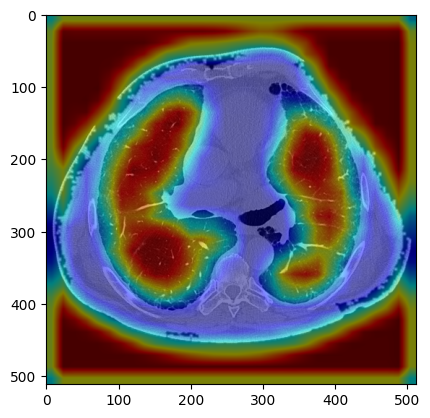

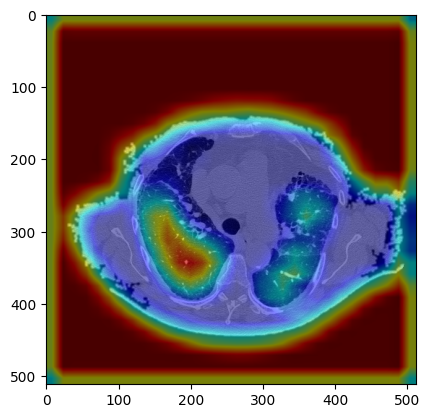

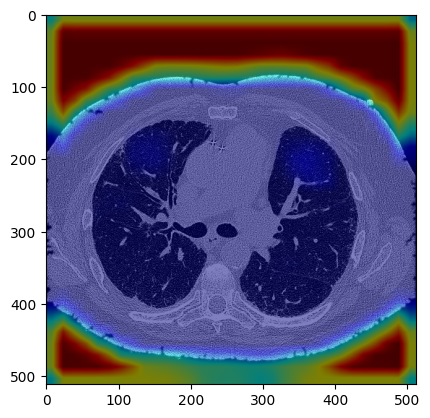

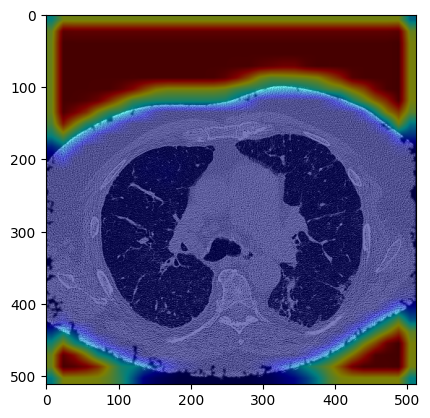

In [30]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import RawScoresOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

scan_idx = 5
for patient_id in list(train_x.keys())[70:74]:
  scans = get_scans(patient_id, scan_count[patient_id], 12)
  input_tensor = torch.tensor(scans[scan_idx], dtype=torch.float32, device=device)
  input_tensor = input_tensor.unsqueeze(0)

  class CNNWithMeanPooling(nn.Module):
    def __init__(self, cnn_model):
      super().__init__()
      self.cnn = cnn_model
    
    def forward(self, x):
      features = self.cnn(x)  # [N, 512]
      return features.mean(dim=0)  # Scalar - mean of all features

  wrapped_cnn = CNNWithMeanPooling(cnn_model)
  wrapped_cnn.to(device)
  wrapped_cnn.eval()

  # print(wrapped_cnn(input_tensor))

  targets = [RawScoresOutputTarget()]
  target_layers = [wrapped_cnn.cnn.conv5]
  with GradCAM(model=wrapped_cnn, target_layers=target_layers) as cam:
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
    input_image = input_tensor.cpu().numpy()
    input_image = input_image.astype(np.float32)
    input_image = (input_image - input_image.min()) / (input_image.max() - input_image.min() + 1e-8)
    input_image = input_image[0].transpose(1, 2, 0)
    cam_image = show_cam_on_image(input_image, grayscale_cam[0, :], use_rgb=True)
    plt.imshow(cam_image)
    plt.show()

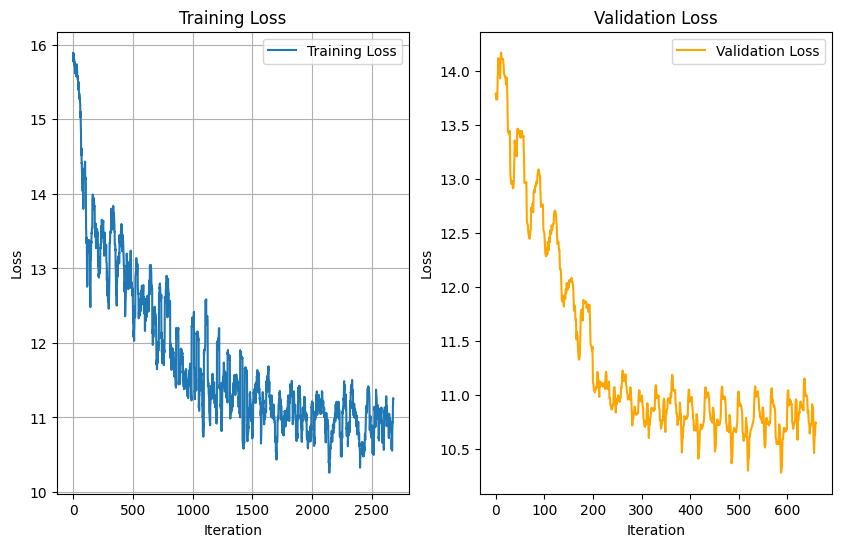

In [27]:
plot_loss(training_loss, val_loss)

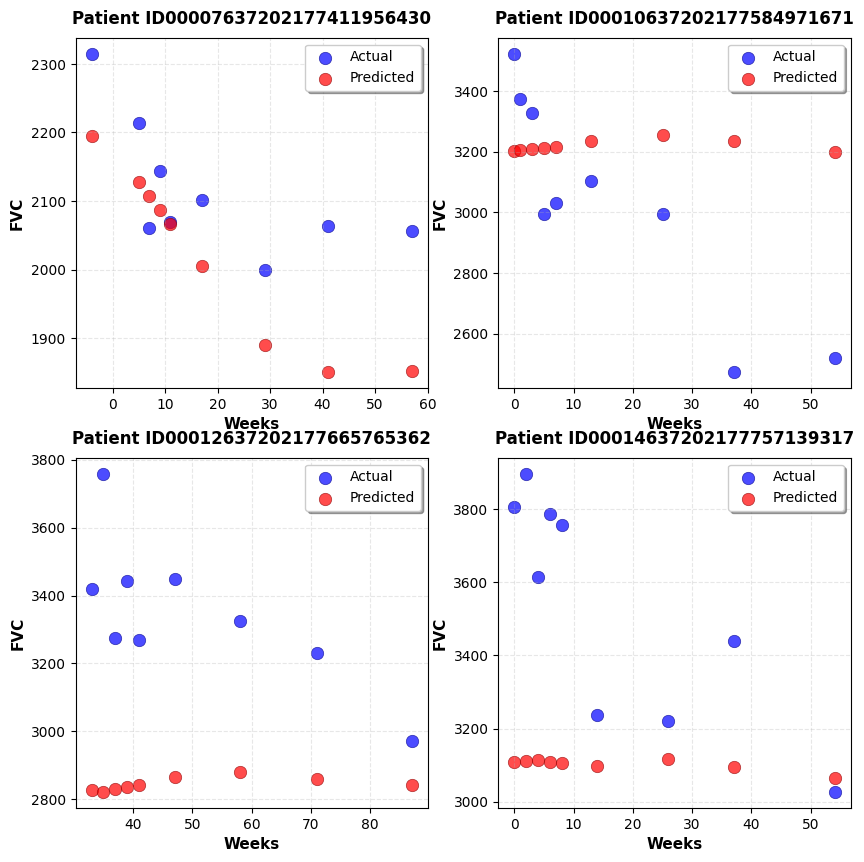

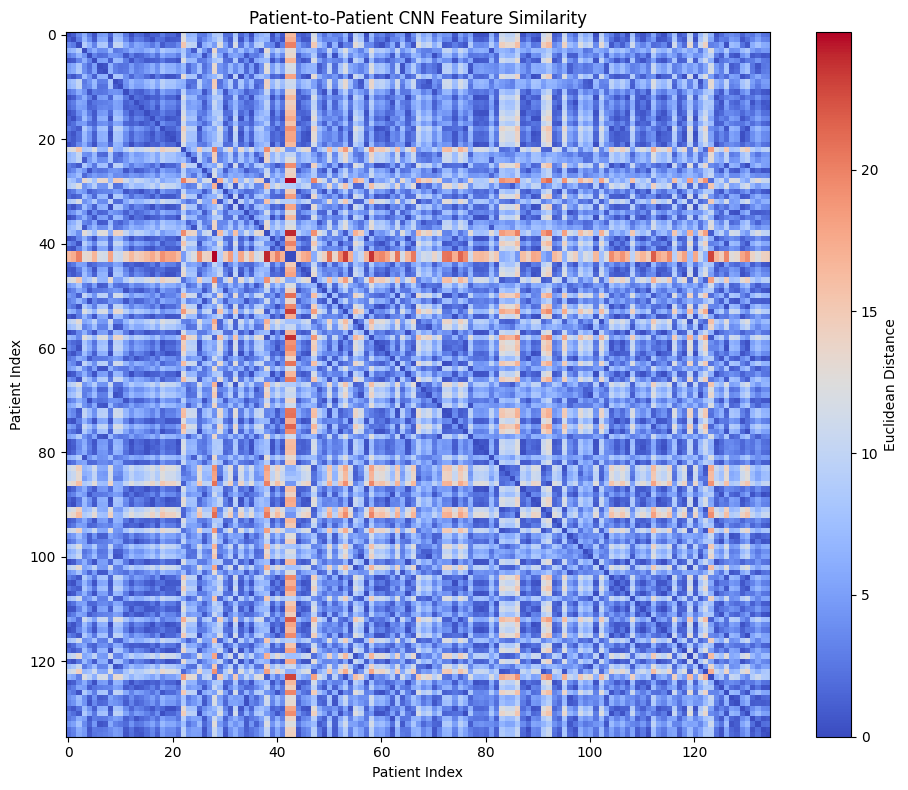

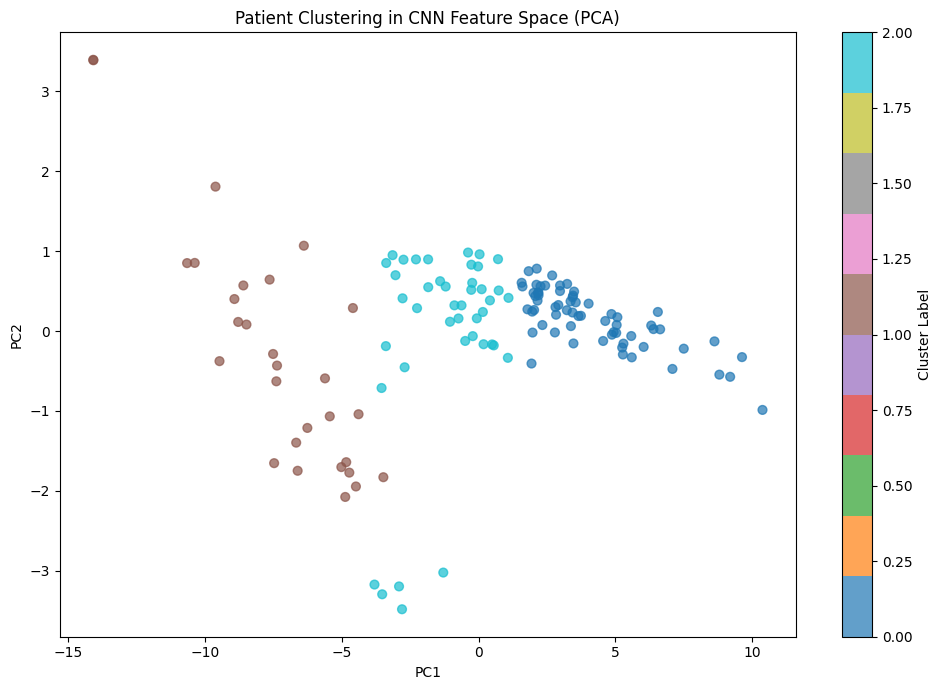

Dead features (always 0): 0/512
Feature min: 0.004
Feature max: 1.444
Feature mean: 0.602
Feature std: 0.232
Percentage of near-zero activations: 0.5%
Top 10 Outliers
Idx: 43, Patient ID: ID00132637202222178761324
Idx: 42, Patient ID: ID00128637202219474716089
Idx: 92, Patient ID: ID00285637202278913507108
Idx: 86, Patient ID: ID00264637202270643353440
Idx: 28, Patient ID: ID00099637202206203080121
Idx: 22, Patient ID: ID00078637202199415319443
Idx: 47, Patient ID: ID00139637202231703564336
Idx: 38, Patient ID: ID00123637202217151272140
Idx: 58, Patient ID: ID00184637202242062969203
Idx: 91, Patient ID: ID00283637202278714365037


<Figure size 640x480 with 0 Axes>

In [28]:
criterion = torch.nn.MSELoss()
plot_patient_predict_samples(cnn_model, fc_model, criterion, scan_batch_size=12)

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [01:29<00:00, 17.85s/it]


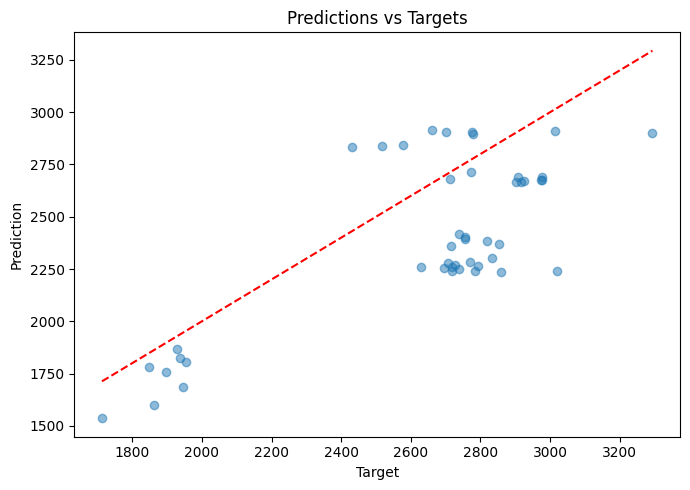

Average Test Loss: 127824.88


In [31]:
test_prediction, test_target = test_model(cnn_model, fc_model)
criterion = torch.nn.MSELoss()
plot_test_results(test_target, test_prediction)
average_loss = np.mean([criterion(test_prediction[i], test_target[i]) for i in range(len(test_prediction))])
print(f'Average Test Loss: {average_loss:.2f}')

### Simple Conv Layers, but Flatten instead of Global Pooling. 

In [47]:
from torch import nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.GroupNorm(4, 32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.GroupNorm(8, 64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.GroupNorm(16, 128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.GroupNorm(32, 256)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn5 = nn.GroupNorm(64, 512)

        self.pool = nn.MaxPool2d(2, 2)
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, scans: torch.Tensor):        # Scans: List of num_slices, 1, 512, 512
        x = F.relu(self.bn1(self.conv1(scans)))
        x = self.pool(x) # num_slices, 32, 256, 256
    
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x) # num_slices, 64, 128, 128
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x) # num_slices, 128, 64, 64

        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(x) # num_slices, 256, 32, 32

        x = F.relu(self.bn5(self.conv5(x)))
        x = self.pool(x) # num_slices, 512, 16, 16

        x = self.global_pool(x) # num_slices, 512, 1, 1
        x = x.view(-1, 512)

        return x

class FCLayer(nn.Module):
    def __init__(self, input_dim=512*12, tabular_dim=30, tabular_norm_stats=None):
        super(FCLayer, self).__init__()
        self.tabular_norm_stats = tabular_norm_stats
        if tabular_norm_stats is not None:
            # Register as buffers (not parameters, but saved with model)
            self.register_buffer('weeks_mean', torch.tensor(tabular_norm_stats['weeks_mean']))
            self.register_buffer('weeks_std', torch.tensor(tabular_norm_stats['weeks_std']))
            self.register_buffer('initial_fvc_mean', torch.tensor(tabular_norm_stats['initial_fvc_mean']))
            self.register_buffer('initial_fvc_std', torch.tensor(tabular_norm_stats['initial_fvc_std']))
            self.register_buffer('initial_weeks_mean', torch.tensor(tabular_norm_stats['initial_weeks_mean']))
            self.register_buffer('initial_weeks_std', torch.tensor(tabular_norm_stats['initial_weeks_std']))

        self.fc1 = nn.Linear(input_dim + tabular_dim, (input_dim + tabular_dim) // 2)
        self.fc2 = nn.Linear((input_dim + tabular_dim) // 2, 256)
        self.fc3 = nn.Linear(256, 1)

        self.tabular_expansion_fc1 = nn.Linear(3, tabular_dim)
        self.tabular_expansion_fc2 = nn.Linear(tabular_dim, tabular_dim)

        # Dropout layers for regularization (NEW)
        self.dropout_tabular = nn.Dropout(p=0.2)  # Light dropout for tabular features
        self.dropout1 = nn.Dropout(p=0.3)  # Moderate dropout after fc1
        self.dropout2 = nn.Dropout(p=0.3)  # Moderate dropout after fc2

        nn.init.kaiming_normal_(
            self.tabular_expansion_fc1.weight, 
            mode='fan_in',
            nonlinearity='relu')
        nn.init.constant_(self.tabular_expansion_fc1.bias, 0.01)
        nn.init.kaiming_normal_(
            self.tabular_expansion_fc2.weight, 
            mode='fan_in',
            nonlinearity='relu')
        
        nn.init.kaiming_normal_(
            self.fc1.weight, 
            mode='fan_in',
            nonlinearity='relu')
        nn.init.constant_(self.fc1.bias, 0.01)
        
        nn.init.kaiming_normal_(
            self.fc2.weight, 
            mode='fan_in',
            nonlinearity='relu')
        nn.init.constant_(self.fc2.bias, 0.01)
        
        nn.init.kaiming_normal_(
            self.fc3.weight, 
            mode='fan_in',
            nonlinearity='relu')        

    def forward(self, features, weeks, initial_FVC, initial_FVC_weeks):
        if self.tabular_norm_stats is not None:
            weeks = (weeks - self.weeks_mean) / self.weeks_std
            initial_FVC = (initial_FVC - self.initial_fvc_mean) / self.initial_fvc_std
            initial_FVC_weeks = (initial_FVC_weeks - self.initial_weeks_mean) / self.initial_weeks_std
        
        tabular_features = torch.cat([weeks, initial_FVC, initial_FVC_weeks])
        tabular_features = F.relu(self.tabular_expansion_fc1(tabular_features))
        tabular_features = self.dropout_tabular(tabular_features)
        tabular_features = self.tabular_expansion_fc2(tabular_features)

        x = torch.cat([features, tabular_features])
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        
        return x

In [48]:
from datetime import datetime
from typing import Any

# Training Loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train_model(cnn_model, fc_model, log_file, epoch=6, learning_rate=0.0001, scan_batch_size=32):
    torch.cuda.empty_cache()

    cnn_model.to(device)
    fc_model.to(device)

    training_loss = []
    val_loss = []

    criterion = nn.MSELoss()

    with open(log_file, 'w') as f:
        f.write(f"Training started: {datetime.now()}\n")
        f.write("="*70 + "\n\n")
    
    cnn_model.train()
    fc_model.train()

    optimizer = torch.optim.AdamW(
        list(cnn_model.parameters()) + list(fc_model.parameters()), 
        lr=learning_rate,
        # weight_decay=1e-5  # L2 regularization
    )

    for epoch in range(epoch):
        print(f"Epoch {epoch}")
        with open(log_file, "a") as f:
            f.write(f"Epoch {epoch}\n")

        patient_count = 0
        patient_list = list(train_x.keys())
        random.shuffle(patient_list)
        for patient_id in tqdm(patient_list):
            x = train_x[patient_id]
            y = train_y[patient_id]
            
            patient_scan_count = scan_count[patient_id]
            scans = get_scans(patient_id, patient_scan_count, scan_batch_size)
            
            total_loss = 0
            for i in range(0, len(x), 4):
                optimizer.zero_grad()
                
                for j in range(i, min(len(x), i+4)):
                    features = cnn_model.forward(scans)
                    features = features.flatten()
                    weeks = torch.tensor(x[j]['Weeks'], dtype=torch.float32, device=device).unsqueeze(0)
                    initial_FVC = torch.tensor(x[j]['initial_FVC'], dtype=torch.float32, device=device).unsqueeze(0)
                    initial_FVC_weeks = torch.tensor(x[j]['initial_weeks'], dtype=torch.float32, device=device).unsqueeze(0)

                    # Forward Pass
                    output = fc_model.forward(features, weeks, initial_FVC, initial_FVC_weeks).squeeze()
                    loss = criterion(output, torch.tensor(y[j], dtype=torch.float32, device=device))
                    loss.backward()
                    total_loss += loss.item()

                optimizer.step()

            patient_count += 1
            
            with open(log_file, "a") as f:
                f.write(f"Epoch {epoch}, Loss: {total_loss / max(len(x), 1)}\n")
            if len(x) == 0:
                print(f"Patient {patient_id} has no data during training")
            training_loss.append(total_loss / max(len(x), 1))
        
            del x, y, features, scans, weeks, initial_FVC, initial_FVC_weeks, output
            torch.cuda.empty_cache()

        # Validation
        with torch.no_grad():
            for patient_id in list[Any](val_x.keys()):
                optimizer.zero_grad()

                patient_scan_count = scan_count[patient_id]
                # Only take a look at "scan_batch_size" number of representive slices from each patient
                scans = get_scans(patient_id, patient_scan_count, scan_batch_size)

                features = cnn_model.forward(scans)
                features = features.flatten()
                
                x = val_x[patient_id]
                y = val_y[patient_id]

                # Accumulate for all datapoints of patient
                accum_loss = 0
                for i in range(len(x)):
                    weeks = torch.tensor(x[i]['Weeks'], dtype=torch.float32, device=device).unsqueeze(0)
                    initial_FVC = torch.tensor(x[i]['initial_FVC'], dtype=torch.float32, device=device).unsqueeze(0)
                    initial_FVC_weeks = torch.tensor(x[i]['initial_weeks'], dtype=torch.float32, device=device).unsqueeze(0)

                    # Forward Pass
                    output = fc_model.forward(features, weeks, initial_FVC, initial_FVC_weeks).squeeze()
                    loss = criterion(output, torch.tensor(y[i], dtype=torch.float32, device=device))
                    accum_loss += loss.item()

                with open(log_file, "a") as f:
                    f.write(f"Epoch {epoch}, Val Loss: {accum_loss / max(len(x), 1)}\n")
                val_loss.append(accum_loss / max(len(x), 1))

                if len(x) == 0:
                    print(f"Patient {patient_id} has no data during validation")

                del x, y, features, scans, weeks, initial_FVC, initial_FVC_weeks, output, loss
                torch.cuda.empty_cache()

        tqdm.write(f"Epoch {epoch} completed")
        # Last 10 training loss, last 10 validation loss
        tqdm.write(f"Training Loss: {sum(training_loss[-10:]) / 10}")
        tqdm.write(f"Validation Loss: {sum(val_loss[-10:]) / 10}")
    return training_loss, val_loss

In [65]:
cnn_model = CNN().to(device)
fc_model = FCLayer(tabular_norm_stats=tabular_stats).to(device)
criterion = torch.nn.MSELoss()
log_file = 'training_log_flatten_cnn_feat.txt'

training_loss, val_loss = train_model(cnn_model, fc_model, log_file, epoch=20, scan_batch_size=12, learning_rate=0.0005)

Epoch 0


100%|██████████| 136/136 [01:44<00:00,  1.30it/s]


Epoch 0 completed
Training Loss: 448563.172736896
Validation Loss: 329262.74012428283
Epoch 1


100%|██████████| 136/136 [01:45<00:00,  1.29it/s]


Epoch 1 completed
Training Loss: 121755.99545986387
Validation Loss: 282424.9858042596
Epoch 2


100%|██████████| 136/136 [01:45<00:00,  1.29it/s]


Epoch 2 completed
Training Loss: 88462.69380045997
Validation Loss: 157675.26788409278
Epoch 3


100%|██████████| 136/136 [01:45<00:00,  1.28it/s]


Epoch 3 completed
Training Loss: 192847.02261754673
Validation Loss: 169265.24887420362
Epoch 4


100%|██████████| 136/136 [01:44<00:00,  1.30it/s]


Epoch 4 completed
Training Loss: 143648.73084896617
Validation Loss: 152423.83717722638
Epoch 5


100%|██████████| 136/136 [01:44<00:00,  1.30it/s]


Epoch 5 completed
Training Loss: 176115.48563692305
Validation Loss: 179274.90997233073
Epoch 6


100%|██████████| 136/136 [01:56<00:00,  1.17it/s]


Epoch 6 completed
Training Loss: 154892.6137257873
Validation Loss: 140441.80382681167
Epoch 7


100%|██████████| 136/136 [01:43<00:00,  1.31it/s]


Epoch 7 completed
Training Loss: 163339.8161661556
Validation Loss: 392760.97539778455
Epoch 8


100%|██████████| 136/136 [01:46<00:00,  1.27it/s]


Epoch 8 completed
Training Loss: 176939.00330243428
Validation Loss: 142782.09666901524
Epoch 9


100%|██████████| 136/136 [01:48<00:00,  1.25it/s]


Epoch 9 completed
Training Loss: 97514.76187746788
Validation Loss: 86532.5790227775
Epoch 10


100%|██████████| 136/136 [01:51<00:00,  1.22it/s]


Epoch 10 completed
Training Loss: 177242.67109753928
Validation Loss: 178814.52315766047
Epoch 11


100%|██████████| 136/136 [01:45<00:00,  1.29it/s]


Epoch 11 completed
Training Loss: 127872.40076025858
Validation Loss: 147485.52079626176
Epoch 12


100%|██████████| 136/136 [01:48<00:00,  1.26it/s]


Epoch 12 completed
Training Loss: 100674.29168064092
Validation Loss: 214381.03051970963
Epoch 13


100%|██████████| 136/136 [01:56<00:00,  1.17it/s]


Epoch 13 completed
Training Loss: 134630.73785246108
Validation Loss: 85730.16006243508
Epoch 14


100%|██████████| 136/136 [01:47<00:00,  1.26it/s]


Epoch 14 completed
Training Loss: 157606.1500145988
Validation Loss: 150218.8081288365
Epoch 15


100%|██████████| 136/136 [01:50<00:00,  1.23it/s]


Epoch 15 completed
Training Loss: 270231.2775341942
Validation Loss: 117678.26198547348
Epoch 16


100%|██████████| 136/136 [01:46<00:00,  1.28it/s]


Epoch 16 completed
Training Loss: 126769.39433572293
Validation Loss: 195361.860160606
Epoch 17


100%|██████████| 136/136 [01:44<00:00,  1.31it/s]


Epoch 17 completed
Training Loss: 117716.45886723201
Validation Loss: 154910.63832852227
Epoch 18


100%|██████████| 136/136 [01:43<00:00,  1.31it/s]


Epoch 18 completed
Training Loss: 181402.90113076105
Validation Loss: 160318.23773677342
Epoch 19


100%|██████████| 136/136 [01:44<00:00,  1.30it/s]


Epoch 19 completed
Training Loss: 95985.5287723128
Validation Loss: 124768.16871754965


In [67]:
analyze_feature_importance(cnn_model, fc_model)

Contribution by cnn feature: 0.5500
Contribution by weeks feature: 0.0164
Contribution by initial_fvc feature: 0.4255
Contribution by initial_weeks feature: 0.0081


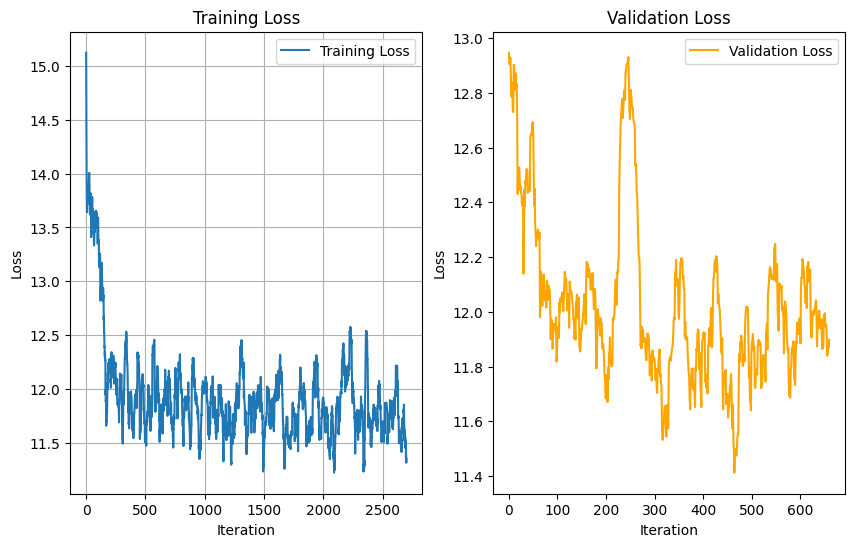

In [68]:
plot_loss(training_loss, val_loss)

In [ ]:
criterion = torch.nn.MSELoss()
plot_patient_predict_samples(cnn_model, fc_model, criterion, 12)

### Improvement to Simple CNN: Imagenet Architecture

In [75]:
from torch import nn
import torch.nn.functional as F

from torch import nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, input_dim=256):
        # Imagenet 34 Layer Architecture
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(),
            nn.MaxPool2d((3, 3), stride=(2, 2))
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.GroupNorm(8, 64),
            nn.ReLU(),
        ) * 6

        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.GroupNorm(16, 128),
            nn.ReLU()
        ) + nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.GroupNorm(16, 128),
            nn.ReLU(),
        ) * 11

        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.GroupNorm(32, 256),
            nn.ReLU(),
        ) + nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.GroupNorm(32, 256),
            nn.ReLU(),
        ) * 5

        self.conv5 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
            nn.GroupNorm(64, 512),
            nn.ReLU(),
        ) + nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.GroupNorm(64, 512),
            nn.ReLU(),
        ) * 2

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, scans: torch.Tensor):
        # Scans: List of num_slices, 1, 256, 256
        x = self.conv1(scans) # num_slices, 64, 63, 63
        x = self.conv2(x) # num_slices, 64, 63, 63
        x = self.conv3(x) # num_slices, 128, 32, 32
        x = self.conv4(x) # num_slices, 256, 16, 16
        x = self.conv5(x) # num_slices, 512, 8, 8
        x = self.global_pool(x) # num_slices, 512, 1, 1
        x = x.view(-1, 512)

        return x

class FCLayer(nn.Module):
    def __init__(self, input_dim=512, tabular_dim=30, tabular_norm_stats=None):
        super(FCLayer, self).__init__()
        self.tabular_norm_stats = tabular_norm_stats
        if tabular_norm_stats is not None:
            # Register as buffers (not parameters, but saved with model)
            self.register_buffer('weeks_mean', torch.tensor(tabular_norm_stats['weeks_mean']))
            self.register_buffer('weeks_std', torch.tensor(tabular_norm_stats['weeks_std']))
            self.register_buffer('initial_fvc_mean', torch.tensor(tabular_norm_stats['initial_fvc_mean']))
            self.register_buffer('initial_fvc_std', torch.tensor(tabular_norm_stats['initial_fvc_std']))
            self.register_buffer('initial_weeks_mean', torch.tensor(tabular_norm_stats['initial_weeks_mean']))
            self.register_buffer('initial_weeks_std', torch.tensor(tabular_norm_stats['initial_weeks_std']))

        self.fc1 = nn.Linear(input_dim + tabular_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 1)

        self.tabular_expansion_fc1 = nn.Linear(3, tabular_dim)
        self.tabular_expansion_fc2 = nn.Linear(tabular_dim, tabular_dim)

        # Dropout layers for regularization (NEW)
        self.dropout_tabular = nn.Dropout(p=0.2)  # Light dropout for tabular features
        self.dropout1 = nn.Dropout(p=0.3)  # Moderate dropout after fc1
        self.dropout2 = nn.Dropout(p=0.3)  # Moderate dropout after fc2

        nn.init.kaiming_normal_(
            self.tabular_expansion_fc1.weight, 
            mode='fan_in',
            nonlinearity='relu')
        nn.init.constant_(self.tabular_expansion_fc1.bias, 0.01)
        nn.init.kaiming_normal_(
            self.tabular_expansion_fc2.weight, 
            mode='fan_in',
            nonlinearity='relu')
        
        nn.init.kaiming_normal_(
            self.fc1.weight, 
            mode='fan_in',
            nonlinearity='relu')
        nn.init.constant_(self.fc1.bias, 0.01)
        
        nn.init.kaiming_normal_(
            self.fc2.weight, 
            mode='fan_in',
            nonlinearity='relu')
        nn.init.constant_(self.fc2.bias, 0.01)
        
        nn.init.kaiming_normal_(
            self.fc3.weight, 
            mode='fan_in',
            nonlinearity='relu')        

    def forward(self, features, weeks, initial_FVC, initial_FVC_weeks):
        if self.tabular_norm_stats is not None:
            weeks = (weeks - self.weeks_mean) / self.weeks_std
            initial_FVC = (initial_FVC - self.initial_fvc_mean) / self.initial_fvc_std
            initial_FVC_weeks = (initial_FVC_weeks - self.initial_weeks_mean) / self.initial_weeks_std
        
        tabular_features = torch.cat([weeks, initial_FVC, initial_FVC_weeks])
        tabular_features = F.relu(self.tabular_expansion_fc1(tabular_features))
        tabular_features = self.dropout_tabular(tabular_features)
        tabular_features = self.tabular_expansion_fc2(tabular_features)

        x = torch.cat([features, tabular_features])
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        
        return x

In [76]:
'''
Employ random selection of scan within partition
to make full use of CT scans available in the dataset
'''

import cv2
from preprocess import get_preprocessed_scan

def get_scans(patient_id: str, patient_scan_count: int, scan_batch_size: int) -> torch.Tensor:
    skip_size = patient_scan_count // scan_batch_size
    remainder = patient_scan_count % scan_batch_size
    scans = []
    curr = 0
    while curr < patient_scan_count:
        next_index = curr + skip_size
        # Ensure exactly #scan_batch_size number of scans
        if remainder > 0:
            remainder -= 1
            next_index += 1

        # Choose random scan inside the partition
        scan_index = random.randint(curr, next_index-1)
        
        scan = get_preprocessed_scan(data_dir, patient_id, scan_index+1)
        if scan is None:
            continue

        scan = torch.tensor(scan, dtype=torch.float32, device=device)
        if scan.shape[1] != 512:
            scan = scan.cpu().numpy().squeeze()
            resized_scan = cv2.resize(scan, (512, 512), interpolation=cv2.INTER_LINEAR)
            scan = resized_scan.reshape(1, 512, 512)
            scan = torch.tensor(scan, dtype=torch.float32, device=device)
        scans.append(scan)

        curr = next_index
        
    scans = torch.stack(scans)
    return scans

In [83]:
from datetime import datetime
from typing import Any

# Training Loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train_model(cnn_model, fc_model, log_file, epoch=6, learning_rate=0.0001, scan_batch_size=32):
    torch.cuda.empty_cache()

    cnn_model.to(device)
    fc_model.to(device)

    training_loss = []
    val_loss = []

    criterion = nn.MSELoss()

    with open(log_file, 'w') as f:
        f.write(f"Training started: {datetime.now()}\n")
        f.write("="*70 + "\n\n")
    
    cnn_model.train()
    fc_model.train()

    optimizer = torch.optim.Adam(
        list(cnn_model.parameters()) + list(fc_model.parameters()), 
        lr=learning_rate,
        # weight_decay=1e-5  # L2 regularization
    )

    for epoch in range(epoch):
        print(f"Epoch {epoch}")
        with open(log_file, "a") as f:
            f.write(f"Epoch {epoch}\n")

        patient_count = 0
        patient_list = list(train_x.keys())
        random.shuffle(patient_list)
        for patient_id in tqdm(patient_list):
            x = train_x[patient_id]
            y = train_y[patient_id]

            patient_scan_count = scan_count[patient_id]
            scans = get_scans(patient_id, patient_scan_count, scan_batch_size)

            total_loss = 0
            for i in range(len(x)):
                optimizer.zero_grad()
                features = cnn_model.forward(scans)
                features = torch.mean(features, dim=0) # 1024,

                weeks = torch.tensor(x[i]['Weeks'], dtype=torch.float32, device=device).unsqueeze(0)
                initial_FVC = torch.tensor(x[i]['initial_FVC'], dtype=torch.float32, device=device).unsqueeze(0)
                initial_FVC_weeks = torch.tensor(x[i]['initial_weeks'], dtype=torch.float32, device=device).unsqueeze(0)

                # Forward Pass
                output = fc_model.forward(features, weeks, initial_FVC, initial_FVC_weeks).squeeze()
                loss = criterion(output, torch.tensor(y[i], dtype=torch.float32, device=device))
                total_loss += loss.item()
                loss.backward()
            
            optimizer.step()
            patient_count += 1
            
            with open(log_file, "a") as f:
                f.write(f"Epoch {epoch}, Loss: {total_loss / max(len(x), 1)}\n")
            if len(x) == 0:
                print(f"Patient {patient_id} has no data during training")
            training_loss.append(total_loss / max(len(x), 1))
        
            del x, y, features, scans, weeks, initial_FVC, initial_FVC_weeks, output
            torch.cuda.empty_cache()

        # Validation
        with torch.no_grad():
            for patient_id in list[Any](val_x.keys()):
                optimizer.zero_grad()

                patient_scan_count = scan_count[patient_id]
                # Only take a look at "scan_batch_size" number of representive slices from each patient
                scans = get_scans(patient_id, patient_scan_count, scan_batch_size)

                features = cnn_model.forward(scans)
                features = torch.mean(features, dim=0)
                
                x = val_x[patient_id]
                y = val_y[patient_id]

                # Accumulate for all datapoints of patient
                accum_loss = 0
                for i in range(len(x)):
                    weeks = torch.tensor(x[i]['Weeks'], dtype=torch.float32, device=device).unsqueeze(0)
                    initial_FVC = torch.tensor(x[i]['initial_FVC'], dtype=torch.float32, device=device).unsqueeze(0)
                    initial_FVC_weeks = torch.tensor(x[i]['initial_weeks'], dtype=torch.float32, device=device).unsqueeze(0)

                    # Forward Pass
                    output = fc_model.forward(features, weeks, initial_FVC, initial_FVC_weeks).squeeze()
                    loss = criterion(output, torch.tensor(y[i], dtype=torch.float32, device=device))
                    accum_loss += loss.item()

                with open(log_file, "a") as f:
                    f.write(f"Epoch {epoch}, Val Loss: {accum_loss / max(len(x), 1)}\n")
                val_loss.append(accum_loss / max(len(x), 1))

                if len(x) == 0:
                    print(f"Patient {patient_id} has no data during validation")

                del x, y, features, scans, weeks, initial_FVC, initial_FVC_weeks, output, loss
                torch.cuda.empty_cache()

        tqdm.write(f"Epoch {epoch} completed")
        # Last 10 training loss, last 10 validation loss
        tqdm.write(f"Training Loss: {sum(training_loss[-10:]) / 10}")
        tqdm.write(f"Validation Loss: {sum(val_loss[-10:]) / 10}")
    return training_loss, val_loss

In [84]:
cnn_model = CNN().to(device)
fc_model = FCLayer(tabular_norm_stats=tabular_stats).to(device)
log_file = 'training_log_imagenet.txt'

training_loss, val_loss = train_model(cnn_model, fc_model, log_file, epoch=10, scan_batch_size=12, learning_rate=0.0005)

Epoch 0


 10%|█         | 14/136 [00:16<02:24,  1.18s/it]


KeyboardInterrupt: 

### Implement Patient-Agonistic Training Loop

In [282]:
# Training Loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train_model(cnn_model, fc_model, criterion, log_file, epoch=6, learning_rate=0.0001, scan_batch_size=64, grad_acculation_steps=4):
    torch.cuda.empty_cache()

    cnn_model.to(device)
    fc_model.to(device)

    training_loss = []
    val_loss = []

    with open(log_file, 'w') as f:
        f.write(f"Training started: {datetime.now()}\n")
        f.write("="*70 + "\n\n")
    
    cnn_model.train()
    fc_model.train()

    optimizer = torch.optim.AdamW(
        list(cnn_model.parameters()) + list(fc_model.parameters()), 
        lr=learning_rate,
        # betas=(0.95, 0.999)
        # weight_decay=1e-5  # L2 regularization
    )

    for epoch in range(epoch):
        print(f"Epoch {epoch}")
        with open(log_file, "a") as f:
            f.write(f"Epoch {epoch}\n")

        train_points = []
        for patient_id in train_x.keys():
            for i in range(len(train_x[patient_id])):
                train_points.append((patient_id, train_x[patient_id][i], train_y[patient_id][i]))
        random.shuffle(train_points)

        for i, (patient_id, x, y) in tqdm(enumerate(train_points), total=len(train_points)):
            if i % grad_acculation_steps == 0:
                total_loss = 0
                optimizer.zero_grad()

            patient_scan_count = scan_count[patient_id]
            scans = get_scans(patient_id, patient_scan_count, scan_batch_size)

            features = cnn_model.forward(scans)
            # features = torch.mean(features, dim=0) # 1024,
            features = features.flatten()

            weeks = torch.tensor(x['Weeks'], dtype=torch.float32, device=device).unsqueeze(0)
            initial_FVC = torch.tensor(x['initial_FVC'], dtype=torch.float32, device=device).unsqueeze(0)
            initial_FVC_weeks = torch.tensor(x['initial_weeks'], dtype=torch.float32, device=device).unsqueeze(0)

            # Forward Pass
            output = fc_model.forward(features, weeks, initial_FVC, initial_FVC_weeks).squeeze()
            loss = criterion(output, torch.tensor(y, dtype=torch.float32, device=device))
            
            total_loss += loss.item()
            loss.backward()
              
            if i % grad_acculation_steps == grad_acculation_steps - 1:
                optimizer.step()

                with open(log_file, "a") as f:
                    f.write(f"Epoch {epoch}, Step: {i}, Loss: {total_loss / grad_acculation_steps}\n")
                if len(x) == 0:
                    print(f"Patient {patient_id} has no data during training")
                training_loss.append(total_loss / grad_acculation_steps)
        
            del features, scans, weeks, initial_FVC, initial_FVC_weeks, output
            torch.cuda.empty_cache()

        # Validation
        with torch.no_grad():
            for patient_id in list[Any](val_x.keys()):
                optimizer.zero_grad()

                patient_scan_count = scan_count[patient_id]
                scans = get_scans(patient_id, patient_scan_count, scan_batch_size)

                features = cnn_model.forward(scans)
                # features = torch.mean(features, dim=0)
                features = features.flatten()
                
                x = val_x[patient_id]
                y = val_y[patient_id]

                # Accumulate for all datapoints of patient
                accum_loss = 0
                for i in range(len(x)):
                    weeks = torch.tensor(x[i]['Weeks'], dtype=torch.float32, device=device).unsqueeze(0)
                    initial_FVC = torch.tensor(x[i]['initial_FVC'], dtype=torch.float32, device=device).unsqueeze(0)
                    initial_FVC_weeks = torch.tensor(x[i]['initial_weeks'], dtype=torch.float32, device=device).unsqueeze(0)

                    # Forward Pass
                    output = fc_model.forward(features, weeks, initial_FVC, initial_FVC_weeks).squeeze()
                    loss = criterion(output, torch.tensor(y[i], dtype=torch.float32, device=device))
                    accum_loss += loss.item()

                with open(log_file, "a") as f:
                    f.write(f"Epoch {epoch}, Val Loss: {accum_loss / max(len(x), 1)}\n")
                val_loss.append(accum_loss / max(len(x), 1))

                if len(x) == 0:
                    print(f"Patient {patient_id} has no data during validation")

                del x, y, features, scans, weeks, initial_FVC, initial_FVC_weeks, output, loss
                torch.cuda.empty_cache()

        tqdm.write(f"Epoch {epoch} completed")
        # Last 10 training loss, last 10 validation loss
        tqdm.write(f"Training Loss: {sum(training_loss[-10:]) / 10}")
        tqdm.write(f"Validation Loss: {sum(val_loss[-10:]) / 10}")
    # print(cnn_grad_norms)
    # print(fc_grad_norms)
    return training_loss, val_loss

In [ ]:
cnn_model = CNN().to(device)
fc_model = FCLayer(tabular_norm_stats=tabular_stats).to(device)
log_file = 'training_log_seqblkcnn.txt'
criterion = nn.HuberLoss(delta=1.0)
# criterion = nn.MSELoss()

training_loss, val_loss = train_model(cnn_model, fc_model, criterion, log_file, epoch=10, scan_batch_size=64, learning_rate=0.0001)

Epoch 0


100%|██████████| 1198/1198 [59:13<00:00,  2.97s/it] 


Epoch 0 completed
Training Loss: 421.032421875
Validation Loss: 607.766336999318
Epoch 1


100%|██████████| 1198/1198 [1:05:28<00:00,  3.28s/it]


Epoch 1 completed
Training Loss: 383.85035400390626
Validation Loss: 494.909354984344
Epoch 2


100%|██████████| 1198/1198 [1:08:33<00:00,  3.43s/it]


Epoch 2 completed
Training Loss: 195.59105585888028
Validation Loss: 224.73442511664499
Epoch 3


100%|██████████| 1198/1198 [1:11:59<00:00,  3.61s/it]


Epoch 3 completed
Training Loss: 282.8105499267578
Validation Loss: 347.0727775840154
Epoch 4


100%|██████████| 1198/1198 [1:13:32<00:00,  3.68s/it]


Epoch 4 completed
Training Loss: 288.7951263427734
Validation Loss: 232.01769385087673
Epoch 5


100%|██████████| 1198/1198 [1:19:23<00:00,  3.98s/it]


Epoch 5 completed
Training Loss: 189.89866332486272
Validation Loss: 190.9523705008295
Epoch 6


100%|██████████| 1198/1198 [1:20:27<00:00,  4.03s/it]


Epoch 6 completed
Training Loss: 183.23766174316407
Validation Loss: 214.54173871721542
Epoch 7


100%|██████████| 1198/1198 [1:20:19<00:00,  4.02s/it]


Epoch 7 completed
Training Loss: 304.4794128417969
Validation Loss: 247.47054253472226
Epoch 8


100%|██████████| 1198/1198 [1:22:42<00:00,  4.14s/it]


Epoch 8 completed
Training Loss: 295.8848175048828
Validation Loss: 228.41966896855644
Epoch 9


 77%|███████▋  | 920/1198 [1:10:13<10:46,  2.32s/it]

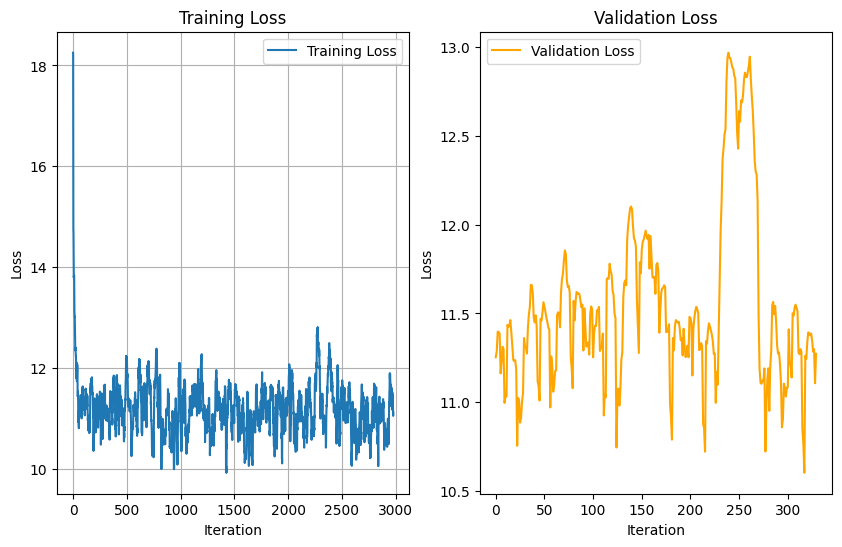

In [114]:
plot_loss(training_loss, val_loss, window=10)

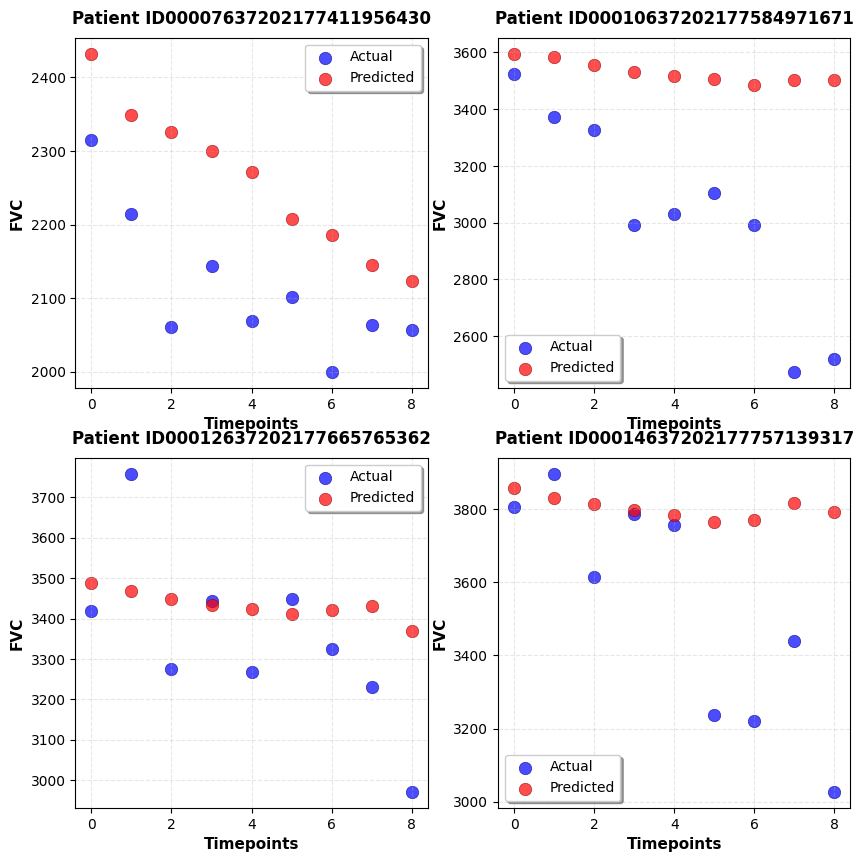

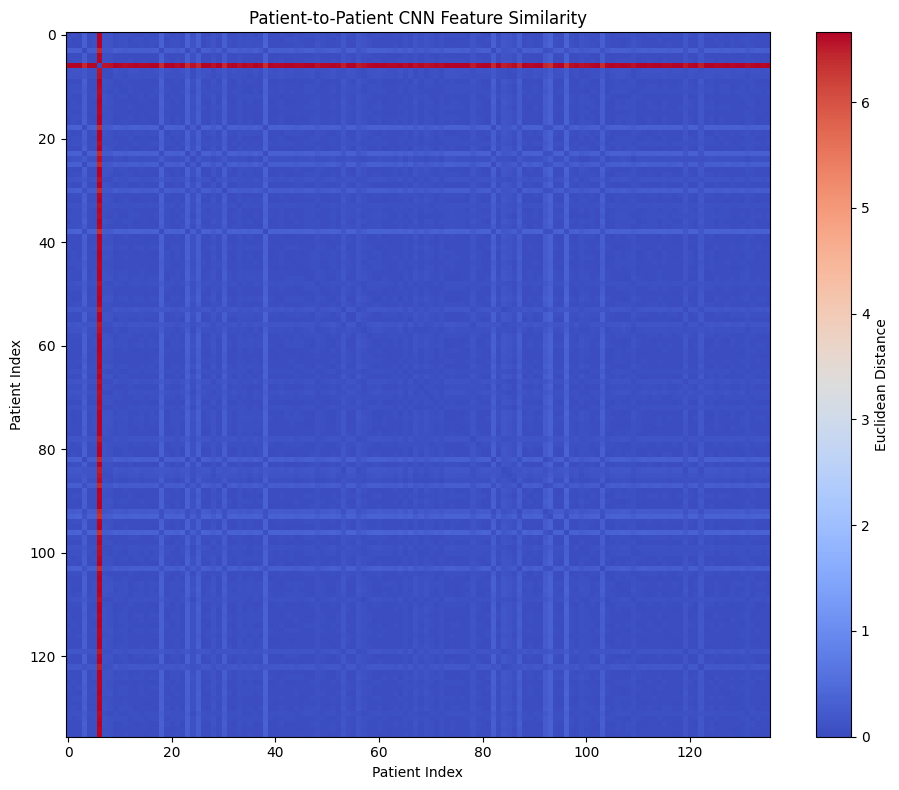

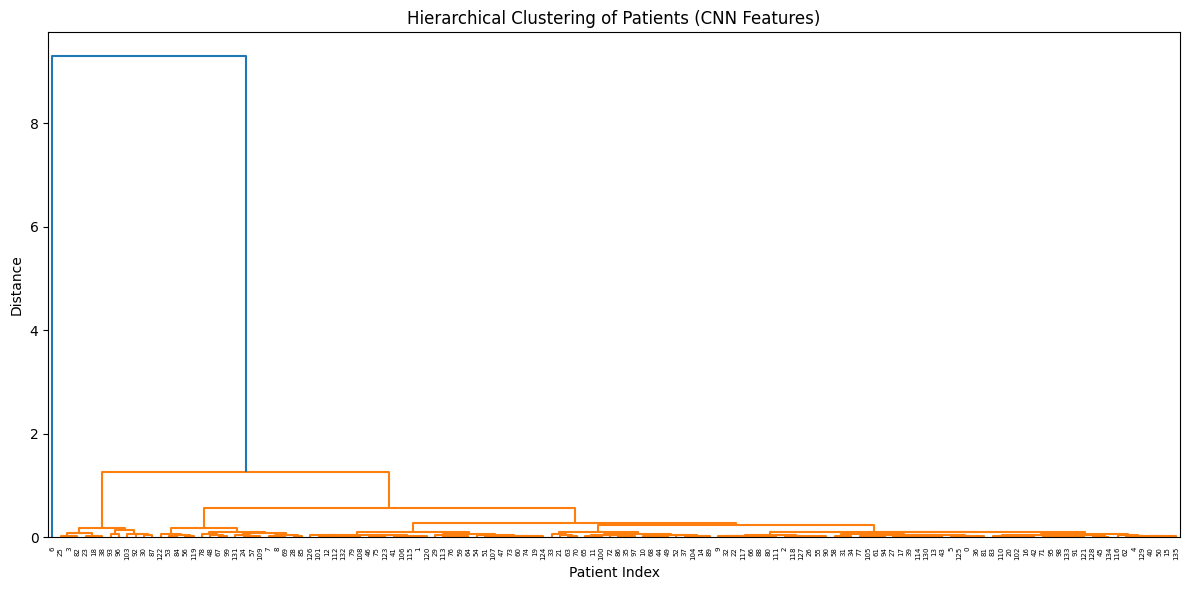

Dead features (always 0): 73/512
Feature min: 0.000
Feature max: 7.887
Feature mean: 1.296
Feature std: 1.279
Percentage of near-zero activations: 15.2%


<Figure size 640x480 with 0 Axes>

In [115]:
plot_patient_predict_samples(cnn_model, fc_model, criterion)

100%|██████████| 5/5 [00:03<00:00,  1.29it/s]


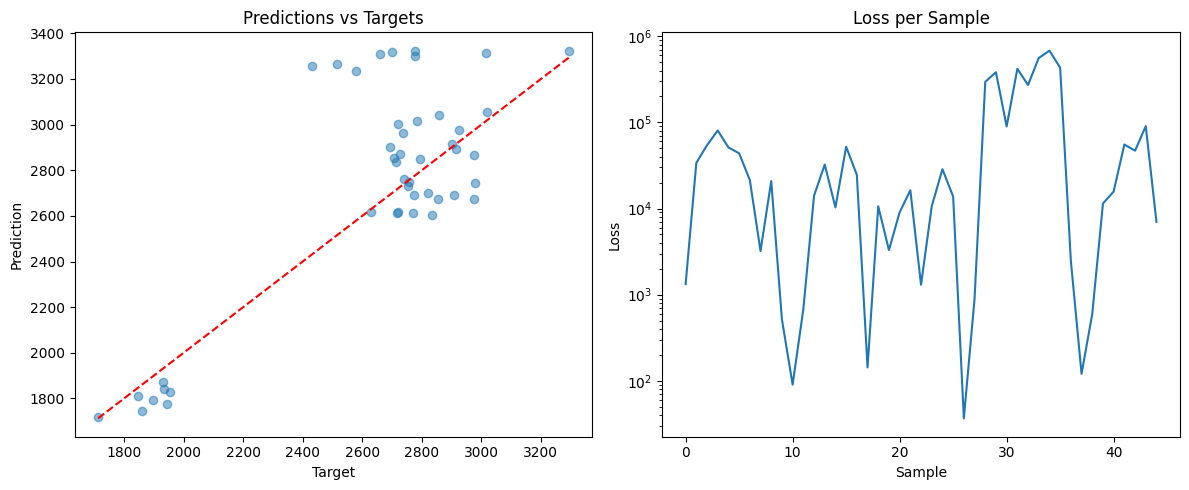

In [20]:
test_prediction, test_target = test_model(cnn_model, fc_model)
loss = torch.nn.MSELoss()
plot_test_results(test_target, test_prediction, [loss(test_prediction[i], test_target[i]) for i in range(len(test_prediction))])

##### Test if model capable of overfitting (Does it have enough analysis power?)

In [ ]:
def test_single_patient_overfit(cnn_model, fc_model):
    """
    Overfit test with full diagnostics
    """
    optimizer = torch.optim.Adam(
        list(cnn_model.parameters()) + list(fc_model.parameters()), 
        lr=0.00005,  # Reduced from 0.0001
    )
    criterion = nn.MSELoss()  # Simpler than Huber for debugging
    
    cnn_model.train()
    fc_model.train()
    
    # Get patient data
    patient = list(train_x.keys())[0]
    x = train_x[patient]  # List of samples
    y = train_y[patient]  # List of targets
    patient_scan_count = scan_count[patient]  # FIXED: was patient_id
    
    print(f"Patient: {patient}")
    print(f"Number of samples: {len(x)}")
    print(f"Targets: {y}")
    print(f"Scan count: {patient_scan_count}\n")
    
    # Load scans once
    scans = get_scans(patient, patient_scan_count, 64)
    print(f"Scans shape: {scans.shape}\n")
    
    for epoch in range(1000):
        # Compute features once per epoch
        
        epoch_losses = []
        epoch_predictions = []
        epoch_targets = []
        
        # Train on all samples
        for i in range(len(x)):
            optimizer.zero_grad()
            features = cnn_model.forward(scans)  # (num_slices, 512)
            features = torch.mean(features, dim=0)  # (512,)
            
            # Prepare tabular inputs
            weeks = torch.tensor(x[i]['Weeks'], dtype=torch.float32, device=device).unsqueeze(0)
            initial_FVC = torch.tensor(x[i]['initial_FVC'], dtype=torch.float32, device=device).unsqueeze(0)
            initial_FVC_weeks = torch.tensor(x[i]['initial_weeks'], dtype=torch.float32, device=device).unsqueeze(0)
            target = torch.tensor(y[i], dtype=torch.float32, device=device)
            
            # Forward pass
            output = fc_model.forward(features, weeks, initial_FVC, initial_FVC_weeks).squeeze()
            loss = criterion(output, target)
            
            # Backward pass
            loss.backward()
            
            optimizer.step()
            
            # Log
            epoch_losses.append(loss.item())
            epoch_predictions.append(output.item())
            epoch_targets.append(target.item())
        
        # Compute epoch statistics
        avg_loss = sum(epoch_losses) / len(epoch_losses)
        max_loss = max(epoch_losses)
        min_loss = min(epoch_losses)
        
        # Print detailed diagnostics every 100 epochs
        if epoch % 100 == 99:
            print(f"Epoch {epoch+1}:")
            print(f"  Loss: Avg={avg_loss:.2f}, Min={min_loss:.2f}, Max={max_loss:.2f}")
            print(f"  Predictions: {[f'{p:.1f}' for p in epoch_predictions]}")
            print(f"  Targets:     {[f'{t:.1f}' for t in epoch_targets]}")
            
            # Check gradient norms
            cnn_grad_norm = sum(p.grad.norm().item() for p in cnn_model.parameters() if p.grad is not None)
            fc_grad_norm = sum(p.grad.norm().item() for p in fc_model.parameters() if p.grad is not None)
            print(f"  Grad norms: CNN={cnn_grad_norm:.3f}, FC={fc_grad_norm:.3f}")
            
            # Check feature statistics
            print(f"  Feature stats: mean={features.mean().item():.3f}, std={features.std().item():.3f}")
            print()
        
        # Early stopping if converged
        if avg_loss < 1.0:
            print(f"Converged at epoch {epoch+1} with loss {avg_loss:.4f}")
            break

# Reset models
cnn_model = CNN().to(device)
fc_model = FCLayer(tabular_norm_stats=tabular_stats).to(device)
test_single_patient_overfit(cnn_model, fc_model)

Patient: ID00007637202177411956430
Number of samples: 9
Targets: [2315, 2214, 2061, 2144, 2069, 2101, 2000, 2064, 2057]
Scan count: 30

Scans shape: torch.Size([30, 1, 512, 512])

Epoch 0:
  Loss: Avg=4455235.69, Min=3972166.75, Max=5358154.50
  Predictions: ['0.2', '3.3', '3.1', '4.7', '3.6', '7.8', '7.0', '7.9', '9.3']
  Targets:     ['2315.0', '2214.0', '2061.0', '2144.0', '2069.0', '2101.0', '2000.0', '2064.0', '2057.0']
  Grad norms: CNN=1.366, FC=0.916
  Feature stats: mean=0.410, std=0.618

Epoch 100:
  Loss: Avg=534413.80, Min=148804.00, Max=817690.56
  Predictions: ['1457.4', '1309.7', '1550.2', '1259.7', '1339.3', '1298.5', '1614.2', '1430.2', '1359.4']
  Targets:     ['2315.0', '2214.0', '2061.0', '2144.0', '2069.0', '2101.0', '2000.0', '2064.0', '2057.0']
  Grad norms: CNN=0.197, FC=1.618
  Feature stats: mean=0.447, std=0.826



In [65]:
cnn_model = CNN().to(device)
fc_model = FCLayer(tabular_norm_stats=tabular_stats).to(device)
log_file = 'training_log_imagenet.txt.txt'
criterion = nn.HuberLoss(delta=1.0)

training_loss, val_loss = train_model(cnn_model, fc_model, criterion, log_file, epoch=5, scan_batch_size=64, learning_rate=0.0001, patient_batch_size=1)

Epoch 0


100%|██████████| 136/136 [02:38<00:00,  1.16s/it]


Epoch 0 completed
Training Loss: 309.92670355902777
Validation Loss: 204.90752407266865
Epoch 1


100%|██████████| 136/136 [02:38<00:00,  1.16s/it]


Epoch 1 completed
Training Loss: 202.387877146403
Validation Loss: 331.73784722222223
Epoch 2


100%|██████████| 136/136 [02:38<00:00,  1.16s/it]


Epoch 2 completed
Training Loss: 230.7164094421599
Validation Loss: 306.9757012939453
Epoch 3


100%|██████████| 136/136 [02:38<00:00,  1.16s/it]


Epoch 3 completed
Training Loss: 174.46507076687283
Validation Loss: 252.69147962782117
Epoch 4


100%|██████████| 136/136 [02:38<00:00,  1.17s/it]


Epoch 4 completed
Training Loss: 165.84882390764022
Validation Loss: 195.83221164279513


In [83]:
training_loss, val_loss = train_model(cnn_model, fc_model, criterion, log_file, epoch=5, scan_batch_size=64, learning_rate=0.0001, patient_batch_size=1)

Epoch 0


100%|██████████| 136/136 [02:38<00:00,  1.17s/it]


Epoch 0 completed
Training Loss: 188.06114997016059
Validation Loss: 254.66514302571613
Epoch 1


100%|██████████| 136/136 [02:38<00:00,  1.17s/it]


Epoch 1 completed
Training Loss: 151.15476076006888
Validation Loss: 180.0670633951823
Epoch 2


100%|██████████| 136/136 [02:38<00:00,  1.17s/it]


Epoch 2 completed
Training Loss: 198.67201775444877
Validation Loss: 229.30929090711805
Epoch 3


100%|██████████| 136/136 [02:38<00:00,  1.17s/it]


Epoch 3 completed
Training Loss: 250.34149949815537
Validation Loss: 155.5762044949002
Epoch 4


100%|██████████| 136/136 [02:38<00:00,  1.17s/it]


Epoch 4 completed
Training Loss: 97.8617097241254
Validation Loss: 135.3109138986137


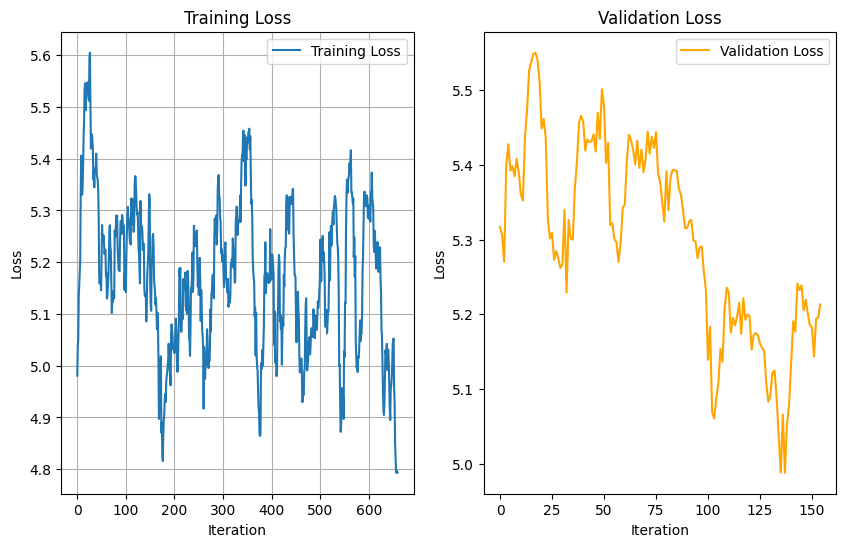

In [84]:
plot_loss(training_loss, val_loss)

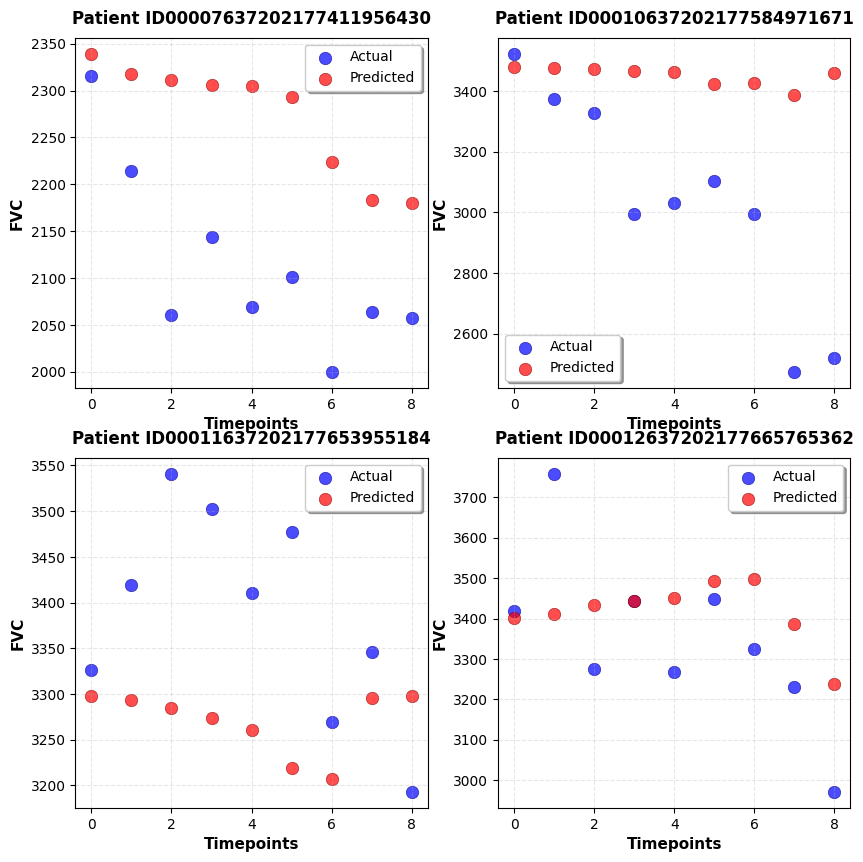

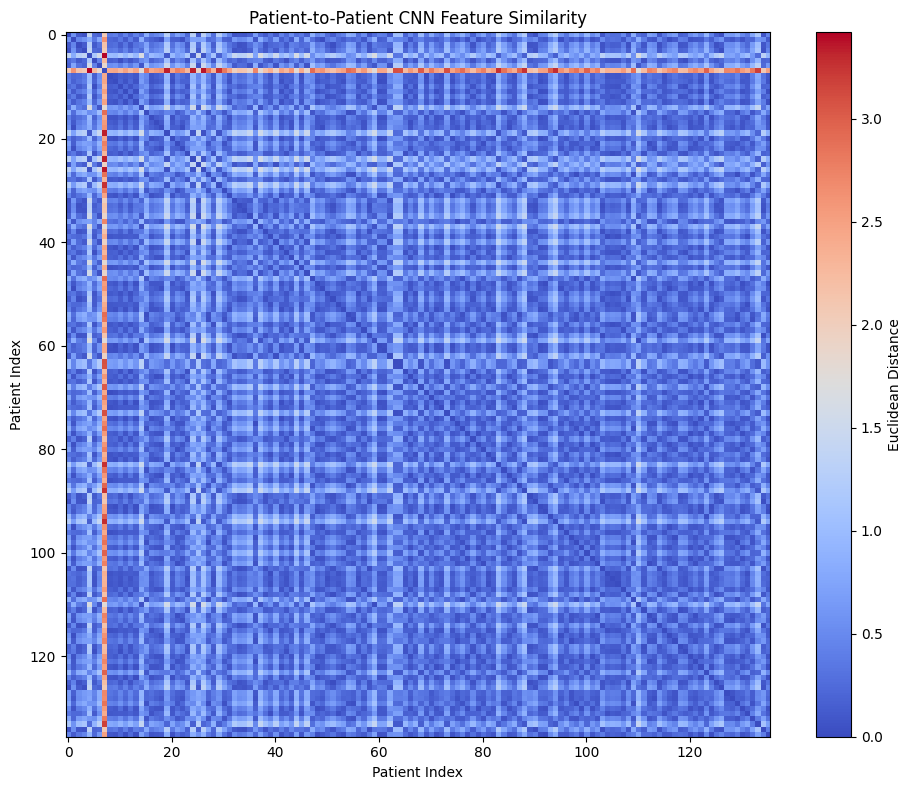

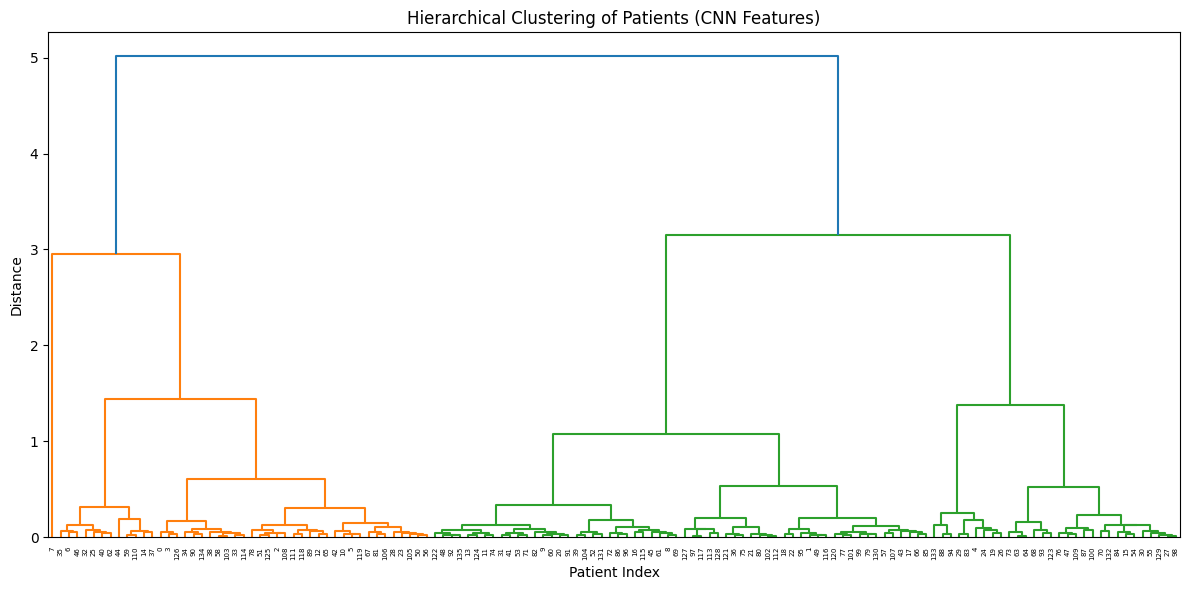

Dead features (always 0): 14/512
Feature min: 0.000
Feature max: 1.182
Feature mean: 0.096
Feature std: 0.189
Percentage of near-zero activations: 48.1%


<Figure size 640x480 with 0 Axes>

In [89]:
plot_patient_predict_samples(cnn_model, fc_model, criterion)

100%|██████████| 5/5 [00:00<00:00,  9.31it/s]


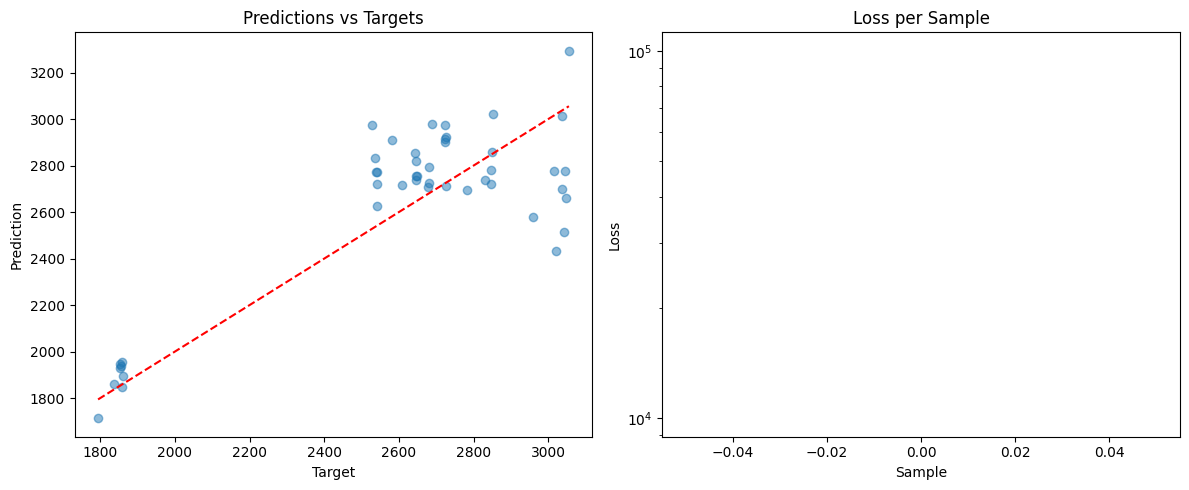

In [72]:
test_prediction, test_target = test_model(cnn_model, fc_model)
loss = torch.nn.MSELoss()
losses = loss(test_prediction, test_target)
plot_test_results(test_prediction, test_target, losses)

### Add Residual Connections (ResNet34)

In [32]:
from torch import nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, input_dim, output_dim, stride):
        super(ResidualBlock, self).__init__()
        self.stride = stride
        self.input_conv = nn.Conv2d(input_dim, output_dim, kernel_size=3, stride=stride, padding=1)
        self.groupnorm1 = nn.GroupNorm(output_dim // 8, output_dim)
        self.second_conv = nn.Conv2d(output_dim, output_dim, kernel_size=3, padding=1)
        self.groupnorm2 = nn.GroupNorm(output_dim // 8, output_dim)

    def forward(self, x):
        residual = x
        x = F.relu(self.groupnorm1(self.input_conv(x)))
        x = self.groupnorm2(self.second_conv(x))
        if self.stride == 1:
            x += residual
        x = F.relu(x)
        return x

class CNN(nn.Module):
    def __init__(self, input_dim=256):
        super(CNN, self).__init__()
        # Add Residual Connections
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(),
            nn.MaxPool2d((3, 3), stride=(2, 2))
        )

        self.conv2 = self._make_layer(64, 64, 1, 3)
        self.conv3 = self._make_layer(64, 128, 2, 4)
        self.conv4 = self._make_layer(128, 256, 2, 6)
        self.conv5 = self._make_layer(256, 512, 2, 3)

        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))

    def _make_layer(self, input_dim, output_dim, stride, num_blocks):
        layers = [ResidualBlock(input_dim, output_dim, stride)]
        layers += [ResidualBlock(output_dim, output_dim, 1) for _ in range(num_blocks - 1)]
        return nn.Sequential(*layers)

    def forward(self, scans: torch.Tensor):
        # Scans: List of num_slices, 1, 256, 256
        x = self.conv1(scans) # num_slices, 64, 63, 63
        x = self.conv2(x) # num_slices, 64, 63, 63
        x = self.conv3(x) # num_slices, 128, 32, 32
        x = self.conv4(x) # num_slices, 256, 16, 16
        x = self.conv5(x) # num_slices, 512, 8, 8
    
        x = self.global_pool(x) # num_slices, 256, 1, 1
        x = x.view(-1, 512)

        return x

class FCLayer(nn.Module):
    def __init__(self, input_dim=512, tabular_dim=30, tabular_norm_stats=None):
        super(FCLayer, self).__init__()
        self.tabular_norm_stats = tabular_norm_stats
        if tabular_norm_stats is not None:
            # Register as buffers (not parameters, but saved with model)
            self.register_buffer('weeks_mean', torch.tensor(tabular_norm_stats['weeks_mean']))
            self.register_buffer('weeks_std', torch.tensor(tabular_norm_stats['weeks_std']))
            self.register_buffer('initial_fvc_mean', torch.tensor(tabular_norm_stats['initial_fvc_mean']))
            self.register_buffer('initial_fvc_std', torch.tensor(tabular_norm_stats['initial_fvc_std']))
            self.register_buffer('initial_weeks_mean', torch.tensor(tabular_norm_stats['initial_weeks_mean']))
            self.register_buffer('initial_weeks_std', torch.tensor(tabular_norm_stats['initial_weeks_std']))

        self.fc1 = nn.Linear(input_dim + tabular_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 1)

        self.tabular_expansion_fc1 = nn.Linear(3, tabular_dim)
        self.tabular_expansion_fc2 = nn.Linear(tabular_dim, tabular_dim)


        nn.init.kaiming_normal_(
            self.tabular_expansion_fc1.weight, 
            mode='fan_in',
            nonlinearity='relu')
        nn.init.constant_(self.tabular_expansion_fc1.bias, 0.01)
        nn.init.kaiming_normal_(
            self.tabular_expansion_fc2.weight, 
            mode='fan_in',
            nonlinearity='relu')
        
        nn.init.kaiming_normal_(
            self.fc1.weight, 
            mode='fan_in',
            nonlinearity='relu')
        nn.init.constant_(self.fc1.bias, 0.01)
        
        nn.init.kaiming_normal_(
            self.fc2.weight, 
            mode='fan_in',
            nonlinearity='relu')
        nn.init.constant_(self.fc2.bias, 0.01)
        
        nn.init.kaiming_normal_(
            self.fc3.weight, 
            mode='fan_in',
            nonlinearity='relu')        

    def forward(self, features, weeks, initial_FVC, initial_FVC_weeks):
        if self.tabular_norm_stats is not None:
            weeks = (weeks - self.weeks_mean) / self.weeks_std
            initial_FVC = (initial_FVC - self.initial_fvc_mean) / self.initial_fvc_std
            initial_FVC_weeks = (initial_FVC_weeks - self.initial_weeks_mean) / self.initial_weeks_std
        
        tabular_features = torch.cat([weeks, initial_FVC, initial_FVC_weeks])
        tabular_features = F.relu(self.tabular_expansion_fc1(tabular_features))
        tabular_features = self.tabular_expansion_fc2(tabular_features)

        x = torch.cat([features, tabular_features])
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        # Denormalize the output
        x = x * self.initial_fvc_std + self.initial_fvc_mean

        return x

In [33]:
cnn_model = CNN().to(device)
fc_model = FCLayer(tabular_norm_stats=tabular_stats).to(device)
log_file = 'training_log_resnet.txt'
criterion = nn.HuberLoss(delta=1.0)

training_loss, val_loss = train_model(cnn_model, fc_model, log_file, epoch=10, scan_batch_size=12, learning_rate=0.0001)

Epoch 0


100%|██████████| 135/135 [02:54<00:00,  1.29s/it]


Epoch 0 completed
Training Loss: 133183.7087690144
Validation Loss: 127109.48006979332
Epoch 1


100%|██████████| 135/135 [03:14<00:00,  1.44s/it]


Epoch 1 completed
Training Loss: 73410.36423288981
Validation Loss: 70775.25920072185
Epoch 2


100%|██████████| 135/135 [03:15<00:00,  1.45s/it]


Epoch 2 completed
Training Loss: 116651.43298796359
Validation Loss: 83454.48050307299
Epoch 3


100%|██████████| 135/135 [02:39<00:00,  1.18s/it]


Epoch 3 completed
Training Loss: 51782.88618724641
Validation Loss: 68382.3867776235
Epoch 4


100%|██████████| 135/135 [02:39<00:00,  1.18s/it]


Epoch 4 completed
Training Loss: 99182.58427283877
Validation Loss: 72882.55841285772
Epoch 5


 76%|███████▌  | 102/135 [02:00<00:38,  1.18s/it]


RuntimeError: cuDNN error: CUDNN_STATUS_INTERNAL_ERROR

In [32]:
plot_patient_predict_samples(cnn_model, fc_model, criterion)

TypeError: plot_patient_predict_samples() missing 1 required positional argument: 'scan_batch_size'

### Use Batchnorm to stabilize weights

In [ ]:
from torch import nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    # Add batchnorm
    def __init__(self, input_dim, output_dim, stride):
        super(ResidualBlock, self).__init__()
        self.stride = stride
        self.input_conv = nn.Conv2d(input_dim, output_dim, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(output_dim)
        self.second_conv = nn.Conv2d(output_dim, output_dim, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(output_dim)

    def forward(self, x):
        residual = x
        x = F.relu(self.bn1(self.input_conv(x)))
        x = self.bn2(self.second_conv(x))
        if self.stride == 1:
            x += residual
        x = F.relu(x)
        return x

class CNN(nn.Module):
    def __init__(self, input_dim=256):
        super(CNN, self).__init__()
        # Add Residual Connections
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(),
            nn.MaxPool2d((3, 3), stride=(2, 2))
        )

        self.conv2 = self._make_layer(64, 64, 1, 3)
        self.conv3 = self._make_layer(64, 128, 2, 4)
        self.conv4 = self._make_layer(128, 256, 2, 6)
        self.conv5 = self._make_layer(256, 512, 2, 3)

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

    def _make_layer(self, input_dim, output_dim, stride, num_blocks):
        layers = [ResidualBlock(input_dim, output_dim, stride)]
        layers += [ResidualBlock(output_dim, output_dim, 1) for _ in range(num_blocks - 1)]
        return nn.Sequential(*layers)

    def forward(self, scans: torch.Tensor):
        # Scans: List of num_slices, 1, 256, 256
        x = self.conv1(scans) # num_slices, 64, 63, 63
        x = self.conv2(x) # num_slices, 64, 63, 63
        x = self.conv3(x) # num_slices, 128, 32, 32
        x = self.conv4(x) # num_slices, 256, 16, 16
        x = self.conv5(x) # num_slices, 512, 8, 8
    
        x = self.global_pool(x) # num_slices, 256, 1, 1
        x = x.view(-1, 512)

        return x

In [32]:
cnn_model = CNN().to(device)
fc_model = FCLayer().to(device)

log_file = 'training_log_resnet_bn.txt'
training_loss, val_loss = train_model(cnn_model, fc_model, log_file, epoch=8, scan_batch_size=64)
plot_loss(training_loss, val_loss)

Epoch 0


100%|██████████| 136/136 [01:58<00:00,  1.15it/s]


Epoch 0 completed
Training Loss: 10171419.402083334
Validation Loss: 1875273.3816529675
Epoch 1


100%|██████████| 136/136 [01:58<00:00,  1.15it/s]


Epoch 1 completed
Training Loss: 1123270.351906467
Validation Loss: 154460.3026026747
Epoch 2


100%|██████████| 136/136 [01:59<00:00,  1.14it/s]


Epoch 2 completed
Training Loss: 175707.74175649483
Validation Loss: 47230.468333183926
Epoch 3


100%|██████████| 136/136 [01:58<00:00,  1.14it/s]


Epoch 3 completed
Training Loss: 195772.04956602785
Validation Loss: 42923.509592605165
Epoch 4


100%|██████████| 136/136 [01:58<00:00,  1.14it/s]


Epoch 4 completed
Training Loss: 311440.4012515108
Validation Loss: 43370.545636223294
Epoch 5


100%|██████████| 136/136 [01:59<00:00,  1.14it/s]


Epoch 5 completed
Training Loss: 240874.33300282937
Validation Loss: 43510.99670375612
Epoch 6


 74%|███████▍  | 101/136 [01:27<00:30,  1.15it/s]


KeyboardInterrupt: 

### Use Bottleneck blocks

In [11]:
from torch import nn
import torch.nn.functional as F

class BottleneckResBlock(nn.Module):
    # Deepen model, use 101 layer resnet architecture
    def __init__(self, input_dim, output_dim, stride, first_block=False):
        super(BottleneckResBlock, self).__init__()
        self.stride = stride
        self.input_conv = nn.Conv2d(input_dim, output_dim, kernel_size=1, stride=stride)
        self.bn1 = nn.BatchNorm2d(output_dim)
        self.second_conv = nn.Conv2d(output_dim, output_dim, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(output_dim)
        self.third_conv = nn.Conv2d(output_dim, output_dim * 4, kernel_size=1)
        self.bn3 = nn.BatchNorm2d(output_dim * 4)

        self.first_block = first_block

    def forward(self, x):
        residual = x
        x = F.relu(self.bn1(self.input_conv(x)))
        x = F.relu(self.bn2(self.second_conv(x)))
        x = self.bn3(self.third_conv(x))

        # If not convx_1
        if not self.first_block:
            x += residual
        x = F.relu(x)
        return x

class CNN(nn.Module):
    def __init__(self, input_dim=256):
        super(CNN, self).__init__()
        # Add Residual Connections
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(),
            nn.MaxPool2d((3, 3), stride=(2, 2))
        )

        self.conv2 = self._make_layer(64, 64, 1, 3)
        self.conv3 = self._make_layer(256, 128, 2, 4)
        self.conv4 = self._make_layer(512, 256, 2, 23)
        self.conv5 = self._make_layer(1024, 512, 2, 3)

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

    def _make_layer(self, input_dim, output_dim, stride, num_blocks):
        layers = [BottleneckResBlock(input_dim, output_dim, stride, first_block=True)]
        layers += [BottleneckResBlock(output_dim * 4, output_dim, 1) for _ in range(num_blocks - 1)]
        return nn.Sequential(*layers)

    def forward(self, scans: torch.Tensor):
        # Scans: List of num_slices, 1, 256, 256
        x = self.conv1(scans) # num_slices, 64, 63, 63
        x = self.conv2(x) # num_slices, 64, 63, 63
        x = self.conv3(x) # num_slices, 128, 32, 32
        x = self.conv4(x) # num_slices, 256, 16, 16
        x = self.conv5(x) # num_slices, 512, 8, 8
    
        x = self.global_pool(x) # num_slices, 256, 1, 1
        x = x.view(x.size(0), -1)

        return x

class FCLayer(nn.Module):
    def __init__(self, input_dim=2048+3):
        super(FCLayer, self).__init__()
        self.fc1 = nn.Linear(input_dim, 2048)
        self.fc2 = nn.Linear(2048, 1024)
        self.fc3 = nn.Linear(1024, 1)

    def forward(self, features, weeks, initial_FVC, initial_FVC_weeks):
        x = torch.cat([features, weeks, initial_FVC, initial_FVC_weeks])
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


Epoch 0


100%|██████████| 136/136 [06:05<00:00,  2.69s/it]


Epoch 0 completed
Training Loss: 667819.0930362048
Validation Loss: 97155.5853611056
Epoch 1


100%|██████████| 136/136 [06:16<00:00,  2.77s/it]


Epoch 1 completed
Training Loss: 209757.71511391798
Validation Loss: 46256.967478790284
Epoch 2


100%|██████████| 136/136 [06:18<00:00,  2.79s/it]


Epoch 2 completed
Training Loss: 148185.1695085537
Validation Loss: 44207.440449318354
Epoch 3


100%|██████████| 136/136 [06:30<00:00,  2.87s/it]


Epoch 3 completed
Training Loss: 290834.1511991519
Validation Loss: 40749.76325650778
Epoch 4


100%|██████████| 136/136 [06:28<00:00,  2.86s/it]


Epoch 4 completed
Training Loss: 270430.78575109807
Validation Loss: 44281.47471906851
Epoch 5


100%|██████████| 136/136 [05:58<00:00,  2.64s/it]


Epoch 5 completed
Training Loss: 325952.886311521
Validation Loss: 42322.56000130124


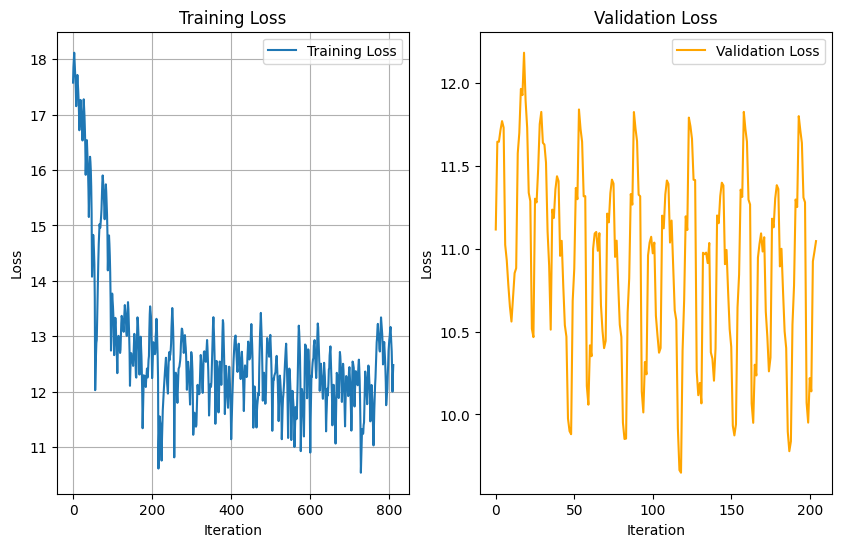

In [12]:
cnn_model = CNN().to(device)
fc_model = FCLayer().to(device)

log_file = 'training_log_resnet_152.txt'
training_loss, val_loss = train_model(cnn_model, fc_model, log_file, epoch=6, scan_batch_size=64)
plot_loss(training_loss, val_loss)

### Analyze top and bottom half of lung separately

In [10]:
from torch import nn
import torch.nn.functional as F

from torch import nn
import torch.nn.functional as F


class BottleneckResBlock(nn.Module):
    # Deepen model, use 101 layer resnet architecture
    def __init__(self, input_dim, output_dim, stride, first_block=False, dropout_rate=0.1):
        super(BottleneckResBlock, self).__init__()
        self.stride = stride
        self.input_conv = nn.Conv2d(input_dim, output_dim, kernel_size=1, stride=stride)
        self.bn1 = nn.BatchNorm2d(output_dim)
        self.second_conv = nn.Conv2d(output_dim, output_dim, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(output_dim)
        self.third_conv = nn.Conv2d(output_dim, output_dim * 4, kernel_size=1)
        self.bn3 = nn.BatchNorm2d(output_dim * 4)
        self.dropout = nn.Dropout2d(p=dropout_rate)

        self.first_block = first_block

    def forward(self, x):
        residual = x
        x = F.relu(self.bn1(self.input_conv(x)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.second_conv(x)))
        x = self.dropout(x)
        x = self.bn3(self.third_conv(x))

        # If not convx_1
        if not self.first_block:
            x += residual
        x = F.relu(x)
        return x

class CNN(nn.Module):
    def __init__(self, input_dim=256, dropout_rate=0.1):
        super(CNN, self).__init__()
        self.dropout_rate = dropout_rate
        # Add Residual Connections
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(),
            nn.MaxPool2d((3, 3), stride=(2, 2)),
            nn.Dropout2d(p=dropout_rate)
        )

        self.conv2 = self._make_layer(64, 64, 1, 3)
        self.conv3 = self._make_layer(256, 128, 2, 4)
        self.conv4 = self._make_layer(512, 256, 2, 6)
        self.conv5 = self._make_layer(1024, 512, 2, 3)

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout_final = nn.Dropout(p=dropout_rate * 2)

    def _make_layer(self, input_dim, output_dim, stride, num_blocks):
        layers = [BottleneckResBlock(input_dim, output_dim, stride, first_block=True, dropout_rate=self.dropout_rate)]
        layers += [BottleneckResBlock(output_dim * 4, output_dim, 1, dropout_rate=self.dropout_rate) for _ in range(num_blocks - 1)]
        return nn.Sequential(*layers)

    def forward(self, scans: torch.Tensor):
        # Scans: List of num_slices, 1, 256, 256
        x = self.conv1(scans) # num_slices, 64, 63, 63
        x = self.conv2(x) # num_slices, 64, 63, 63
        x = self.conv3(x) # num_slices, 128, 32, 32
        x = self.conv4(x) # num_slices, 256, 16, 16
        x = self.conv5(x) # num_slices, 512, 8, 8
    
        x = self.global_pool(x) # num_slices, 256, 1, 1
        x = x.view(-1, 512)
        x = self.dropout_final(x)

        return x

class FCLayer(nn.Module):
    def __init__(self, partition_count, dropout_rate=0.3):
        super(FCLayer, self).__init__()
        self.fc1 = nn.Linear(512 * partition_count + 3, 512 * partition_count // 4)
        self.dropout1 = nn.Dropout(p=dropout_rate)
        self.fc2 = nn.Linear(512 * partition_count // 4, 100)
        self.dropout2 = nn.Dropout(p=dropout_rate)
        self.fc3 = nn.Linear(100, 1)

    def forward(self, features, weeks, initial_FVC, initial_FVC_weeks):
        x = torch.cat([features, weeks, initial_FVC, initial_FVC_weeks])
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x


In [ ]:
from datetime import datetime

from preprocess import get_preprocessed_scan

# Training Loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def get_scans(patient_id: str, patient_scan_count: int, partition_count: int, scan_batch_size: int) -> torch.Tensor:
    scans = []
    scan_per_partition = math.floor(patient_scan_count / partition_count)
    for part_idx in range(partition_count):
        partition = []
        part_start, part_end = part_idx * scan_per_partition, (part_idx + 1) * scan_per_partition
        skip_size = max(1, round(scan_per_partition / scan_batch_size))
        for scan_idx in range(part_start, part_end, skip_size):
            scan = get_preprocessed_scan(data_dir, patient_id, scan_idx)
            if scan is None:
                continue
            scan = torch.tensor(scan, dtype=torch.float32, device=device)
            partition.append(scan)
        scans.append(torch.stack(partition))
    return scans

def train_model(cnn_model: CNN, fc_model: FCLayer, log_file: str, epoch=6, learning_rate=0.001, partition_count=2, scan_batch_size=32):
    torch.cuda.empty_cache()

    training_loss = []
    val_loss = []

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(
        list(cnn_model.parameters()) + list(fc_model.parameters()), lr=learning_rate
    )

    with open(log_file, 'w') as f:
        f.write(f"Training started: {datetime.now()}\n")
        f.write("="*70 + "\n\n")

    for epoch in range(epoch):
        print(f"Epoch {epoch}")
        with open(log_file, "a") as f:
            f.write(f"Epoch {epoch}\n")
        cnn_model.train()
        fc_model.train()

        patient_count = 0
        # accum_loss = 0
        patient_list = list(train_x.keys())
        random.shuffle(patient_list)
        for patient_id in tqdm(patient_list):
            # if patient_count % 4 == 0:
            #     optimizer.zero_grad()
            #     accum_loss = 0

            patient_scan_count = scan_count[patient_id]
            scans = get_scans(patient_id, patient_scan_count, partition_count, scan_batch_size)


            x = train_x[patient_id]
            y = train_y[patient_id]

            # Accumulate loss for stat purpose
            accum_loss = 0

            # For each datapoint, forward pass and backward pass
            for i in range(len(x)):
                optimizer.zero_grad()

                features = []
                for i in range(partition_count):
                    feature = cnn_model.forward(scans[i])
                    features.append(torch.mean(feature, dim=0))
                features = torch.cat(features, dim=0).flatten()

                weeks = torch.tensor(x[i]['Weeks'], dtype=torch.float32, device=device).unsqueeze(0)
                initial_FVC = torch.tensor(x[i]['initial_FVC'], dtype=torch.float32, device=device).unsqueeze(0)
                initial_FVC_weeks = torch.tensor(x[i]['initial_weeks'], dtype=torch.float32, device=device).unsqueeze(0)

                # Forward Pass
                output = fc_model.forward(features, weeks, initial_FVC, initial_FVC_weeks).squeeze()
                # accum_loss += criterion(output, torch.tensor(y[i], dtype=torch.float32, device=device))
                loss = criterion(output, torch.tensor(y[i], dtype=torch.float32, device=device))
                loss.backward()
                optimizer.step()
                accum_loss += loss.item()


            # accum_loss.backward()
            # optimizer.step()
            training_loss.append(accum_loss / max(len(x), 1))
            
            if patient_count == 130:
                print(f"Feature mean: {features.mean():.4f}")
                print(f"Feature std: {features.std():.4f}")
            patient_count += 1
            # Update parameters based on batch of 8 patients
            # if patient_count % 4 == 3:
            #     accum_loss.backward()
            #     optimizer.step()
            #     print(f"Feature mean: {features.mean():.4f}")
            #     print(f"Feature std: {features.std():.4f}")
            #     with open(log_file, "a") as f:
            #         f.write(f"Epoch {epoch}, Loss: {accum_loss.item() / max(len(x), 1)}\n")
            #         training_loss.append(accum_loss / max(len(x), 1))
            #     del accum_loss
            # patient_count += 1
            

        
            del x, y, features, scans, weeks, initial_FVC, initial_FVC_weeks, output, accum_loss
            torch.cuda.empty_cache()

        # Validation
        with torch.no_grad():
            for patient_id in list(val_x.keys()):
                optimizer.zero_grad()

                patient_scan_count = scan_count[patient_id]
                scans = get_scans(patient_id, patient_scan_count, partition_count, scan_batch_size)

                features = []
                for i in range(partition_count):
                    feature = cnn_model.forward(scans[i])
                    features.append(torch.mean(feature, dim=0))
                features = torch.cat(features, dim=0).flatten()

                x = val_x[patient_id]
                y = val_y[patient_id]

                # Accumulate for all datapoints of patient
                accum_loss = 0
                for i in range(len(x)):
                    weeks = torch.tensor(x[i]['Weeks'], dtype=torch.float32, device=device).unsqueeze(0)
                    initial_FVC = torch.tensor(x[i]['initial_FVC'], dtype=torch.float32, device=device).unsqueeze(0)
                    initial_FVC_weeks = torch.tensor(x[i]['initial_weeks'], dtype=torch.float32, device=device).unsqueeze(0)

                    # Forward Pass
                    output = fc_model.forward(features, weeks, initial_FVC, initial_FVC_weeks).squeeze()
                    
                    loss = criterion(output, torch.tensor(y[i], dtype=torch.float32, device=device))
                    accum_loss += loss.item()

                with open(log_file, "a") as f:
                    f.write(f"Epoch {epoch}, Val Loss: {accum_loss / max(len(x), 1)}\n")
                val_loss.append(accum_loss / max(len(x), 1))

                if len(x) == 0:
                    print(f"Patient {patient_id} has no data during validation")

                del x, y, features, scans, weeks, initial_FVC, initial_FVC_weeks, output, loss
                torch.cuda.empty_cache()

        tqdm.write(f"Epoch {epoch} completed")
        # Last 10 training loss, last 10 validation loss
        tqdm.write(f"Training Loss: {sum(training_loss[-10:]) / 10}")
        tqdm.write(f"Validation Loss: {sum(val_loss[-10:]) / 10}")
    return training_loss, val_loss

In [12]:
from preprocess import get_test_preprocessed_scan

def test_model(cnn_models, fc_model, partition_count=2, scan_batch_size=64):
    for cnn_model in cnn_models:
        cnn_model.eval()
    fc_model.eval()

    test_predictions = []
    test_target = []

    for patient_id in tqdm(test_patient_ids):
        patient_scan_count = test_scan_count[patient_id]
        scans = get_scans(patient_id, patient_scan_count, partition_count, scan_batch_size)
        features = []
        for i in range(partition_count):
            feature = cnn_models[i].forward(scans[i])
            features.append(torch.mean(feature, dim=0))
        features = torch.cat(features, dim=0).flatten()

        x = test_x[patient_id]
        y = test_y[patient_id]

        for i in range(len(x)):
            weeks = torch.tensor(x[i]['Weeks'], dtype=torch.float32, device=device).unsqueeze(0)
            initial_FVC = torch.tensor(x[i]['initial_FVC'], dtype=torch.float32, device=device).unsqueeze(0)
            initial_FVC_weeks = torch.tensor(x[i]['initial_weeks'], dtype=torch.float32, device=device).unsqueeze(0)

            output = fc_model.forward(features, weeks, initial_FVC, initial_FVC_weeks).squeeze()
            test_predictions.append(output.item())
            test_target.append(y[i])

        del x, y, features, scans, weeks, initial_FVC, initial_FVC_weeks, output
        torch.cuda.empty_cache()
    
    return torch.tensor(test_predictions), torch.tensor(test_target)

Epoch 0


 96%|█████████▋| 131/136 [04:55<00:10,  2.07s/it]

Feature mean: 0.3726
Feature std: 0.0618


100%|██████████| 136/136 [05:07<00:00,  2.26s/it]


Epoch 0 completed
Training Loss: 155185.12353634305
Validation Loss: 179111.58716387922
Epoch 1


 96%|█████████▋| 131/136 [04:24<00:11,  2.29s/it]

Feature mean: 0.2328
Feature std: 0.0434


100%|██████████| 136/136 [04:34<00:00,  2.02s/it]


Epoch 1 completed
Training Loss: 129201.75251117055
Validation Loss: 245942.50359031782
Epoch 2


 96%|█████████▋| 131/136 [04:23<00:10,  2.15s/it]

Feature mean: 0.1256
Feature std: 0.0294


100%|██████████| 136/136 [04:34<00:00,  2.01s/it]


Epoch 2 completed
Training Loss: 203600.0089995999
Validation Loss: 180476.9363442858
Epoch 3


 96%|█████████▋| 131/136 [04:23<00:09,  1.89s/it]

Feature mean: 0.6432
Feature std: 0.0568


100%|██████████| 136/136 [04:33<00:00,  2.01s/it]


Epoch 3 completed
Training Loss: 178461.12029605443
Validation Loss: 178910.1704472754
Epoch 4


 96%|█████████▋| 131/136 [04:26<00:07,  1.48s/it]

Feature mean: 0.0780
Feature std: 0.0302


100%|██████████| 136/136 [04:34<00:00,  2.02s/it]


Epoch 4 completed
Training Loss: 201670.3846994916
Validation Loss: 186100.09874464248
Epoch 5


 96%|█████████▋| 131/136 [04:24<00:06,  1.28s/it]

Feature mean: 0.0459
Feature std: 0.0209


100%|██████████| 136/136 [04:34<00:00,  2.02s/it]


Epoch 5 completed
Training Loss: 133576.05266017278
Validation Loss: 164550.67864883423
Epoch 6


 96%|█████████▋| 131/136 [04:25<00:12,  2.40s/it]

Feature mean: 0.0490
Feature std: 0.0177


100%|██████████| 136/136 [04:34<00:00,  2.02s/it]


Epoch 6 completed
Training Loss: 179841.28394714356
Validation Loss: 252408.94001993816
Epoch 7


 96%|█████████▋| 131/136 [04:25<00:09,  1.93s/it]

Feature mean: 0.0113
Feature std: 0.0077


100%|██████████| 136/136 [04:34<00:00,  2.02s/it]


Epoch 7 completed
Training Loss: 135129.31214817593
Validation Loss: 246303.93169339924
Epoch 8


 96%|█████████▋| 131/136 [04:25<00:09,  1.88s/it]

Feature mean: 0.0109
Feature std: 0.0098


100%|██████████| 136/136 [04:34<00:00,  2.02s/it]


Epoch 8 completed
Training Loss: 168431.17493760266
Validation Loss: 217720.31133607653
Epoch 9


 96%|█████████▋| 131/136 [04:21<00:09,  1.99s/it]

Feature mean: 0.0040
Feature std: 0.0069


100%|██████████| 136/136 [04:34<00:00,  2.02s/it]


Epoch 9 completed
Training Loss: 126111.29242416487
Validation Loss: 219540.72166845325


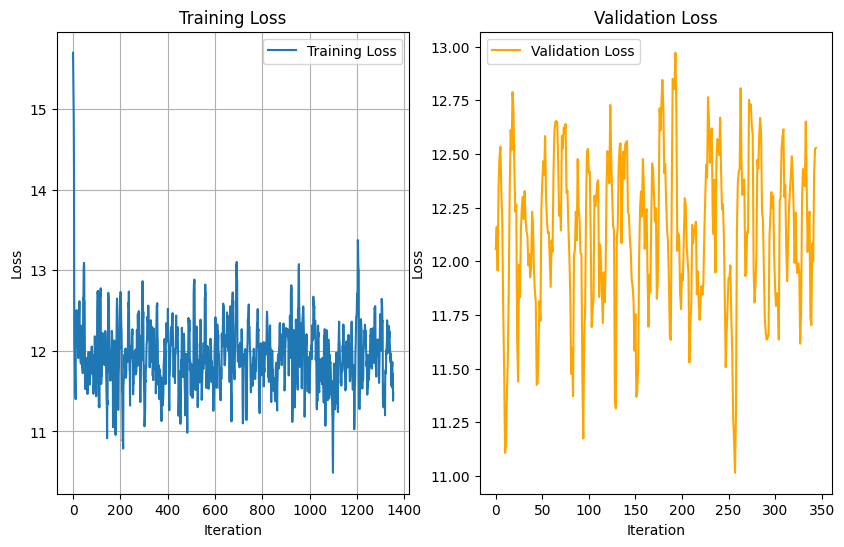

In [14]:
log_file = 'training_log_top_bottom_analysis.txt'

partition_count = 1

# cnn_models = [CNN().to(device) for _ in range(partition_count)]
cnn_model = CNN().to(device)
fc_model = FCLayer(partition_count).to(device)

training_loss, val_loss = train_model(cnn_model, fc_model, log_file, epoch=10, partition_count=1, scan_batch_size=64)
plot_loss(training_loss, val_loss)

100%|██████████| 5/5 [00:07<00:00,  1.44s/it]


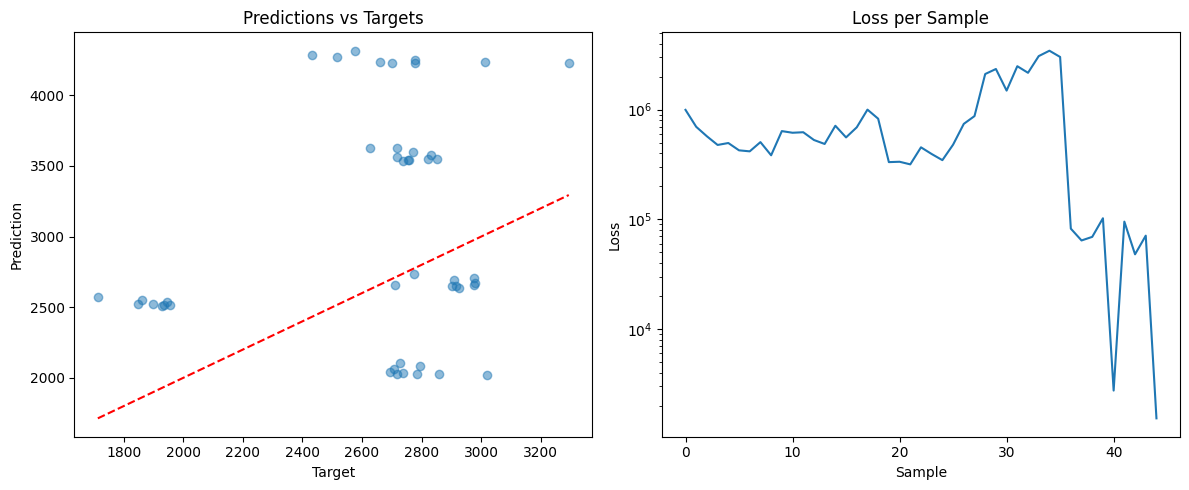

In [24]:
test_prediction, test_target = test_model(cnn_models, fc_model)
loss = torch.nn.MSELoss()
plot_test_results(test_target, test_prediction, [loss(test_prediction[i], test_target[i]) for i in range(len(test_prediction))])

In [17]:
predictions = test_prediction
targets = test_target
# 1. Check if model is just predicting initial_FVC
print("Correlation between predictions and initial_FVC:")
initial_fvc_vals = [val_x[pid][i]['initial_FVC'] for pid in val_x.keys() for i in range(len(val_x[pid]))]
print(f"Corr(pred, initial_FVC): {np.corrcoef(predictions, initial_fvc_vals)[0,1]:.4f}")
print(f"Corr(pred, targets): {np.corrcoef(predictions, targets)[0,1]:.4f}")

# 2. Check unique prediction values (should be many, not just a few)
unique_preds = np.unique(np.round(predictions, -1))  # Round to nearest 10
print(f"Number of distinct prediction values (±10ml): {len(unique_preds)}")
print(f"Most common predictions: {np.round(np.bincount(np.round(predictions).astype(int)).argsort()[-5:], -1)}")

# 3. Baseline comparison
baseline_predictions = initial_fvc_vals  # Just predict initial_FVC
baseline_mae = np.mean(np.abs(np.array(targets) - np.array(baseline_predictions)))
model_mae = np.mean(np.abs(np.array(targets) - np.array(predictions)))
print(f"Baseline MAE (just initial_FVC): {baseline_mae:.1f}")
print(f"Model MAE: {model_mae:.1f}")
print(f"Improvement: {baseline_mae - model_mae:.1f} ml")

# 4. Check prediction variance
print(f"Target std: {np.std(targets):.1f}")
print(f"Prediction std: {np.std(predictions):.1f}")
# If prediction std << target std, model is underconfident/conservativepse
# 4. **Try simpler baseline** - predict `initial_FVC + weeks * learned_rate` to establish lower bound
# 5. **Increase FC layer depth** - add 1-2 more layers with dropout
# 6. **Use Huber loss instead of MSE** - more robust to outliers
# 7. **Add learning rate scheduler** - may be stuck in local minimum

# The horizontal banding is the **clearest signal** that your model has collapsed to predicting only a few discrete values rather than learning continuous relationships. This is often caused by incorrect gradient flow (like `retain_graph=True` issue) or insufficient model capacity in the FC layers.

Correlation between predictions and initial_FVC:


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 45 and the array at index 1 has size 314